# はじめに
CANS+ での解析・可視化ツールであるIDL（Interactive Data Language）の基本的な使い方と、用意されているIDLプロシージャ及びアニメーションの作り方を説明します。IDLのバージョンが8.0以降では、グラフィックス環境が大きく変わり、可視化が容易かつ洗練されました。pythonやそれをベースとしたmatplotlibと文法が非常に似ていますので、両者は親和性が高いです。

jupyter notebookは、pythonプログラミング及びmatplotlibによる可視化などのチュートリアル／ハンズオンのための便利なツールとして知られています。IDL v8.5よりIDLのカーネルも用意され、jupyter notebook上でIDLを利用できるようになりました。本note bookはidl python bridge及びjupyter notebookのセットアップができている環境下で動作します。インストール等、詳細は http://www.harrisgeospatial.com/docs/IDL_Kernel.html を参照してください。    

## jupyter notebookの起動
```console
$ jupyter-notebook IDL_hanbs-on.ipynb
```

で起動します。ブラウザが立ち上がり、ブラウザのページの中でコマンドをインタラクティブに実行していきます。以下ではCANS+ のデータ読み込み、それらの可視化機能、解析手法の紹介をします。以下で使われるプロシージャの一部は \$CANSPLUS_DIR/idl 内に用意されています。これらは各課題から共通して使えるものです。

## 環境変数の設定
環境変数\$IDL\_STARTUPに\$CANSPLUS_DIR/idl/init.proを設定します。

bashの場合、

```bash
$ export IDL_STARTUP=$CANSPLUS_DIR/idl/init.pro
```

tcshの場合、

```csh
$ setenv IDL_STARTUP $CANSPLUS_DIR/idl/init.pro
```

$CANSPLUS_DIR/idl/init.pro内には、pathの設定、IDL内の環境の設定等が含まれており、IDL起動時に自動的に設定されます。各自の好みに合わせて修正してください。

# データの読み込み
オリジナル CANS で使われていたバイナリデータフォーマットであるDAC形式データを読み込む共通プロシージャが用意されています。各MPIプロセスごとに出力されたデータをまとめて一つの配列に格納します。

```dac_read.pro

Name
  dac_read
  
Syntax
  dac_read,data,x,y,filename 　;2D データ
  dac_read,data,x,y,z,filename ;3D データ

Arguments
  data
    記録するデータ配列

  x, y(, z)
    シミュレーションのセル幅から計算した、ｘ，ｙ(，ｚ)軸

  filename
    読み込むデータのファイル名。ワイルドカードが使え、パターンに
    マッチしたファイルを一度に読み込む。ただし、読みこむ全ての数
    値データ配列数は等しい必要がある。

Example1
  IDL> dac_read,bx,x,y,z,'010000_bx_rank=*.dac'

Example2
  IDL> dac_read,bxall,x,y,z,'0[1-5]0?00_bx_rank=*.dac'

```

IDLの作業ディレクトリがhomeになっているので、データのあるディレクトリに移動

In [0]:
pushd, getenv('CANSPLUS_DIR')+'notebook/'

21番目のスナップショットの全ての変数についてデータを読み込む

In [1]:
;dac_read,data,x,y,'0021*'
restore,'sample.dat'

In [2]:
help,data

DATA FLOAT = Array[126, 160, 10]

# 1次元プロット
詳細については
```IDL
IDL> ?plot
```
で調べてください。    
まずは、x=Lx/2でのシア方向（y方向）のvxの1次元プロット

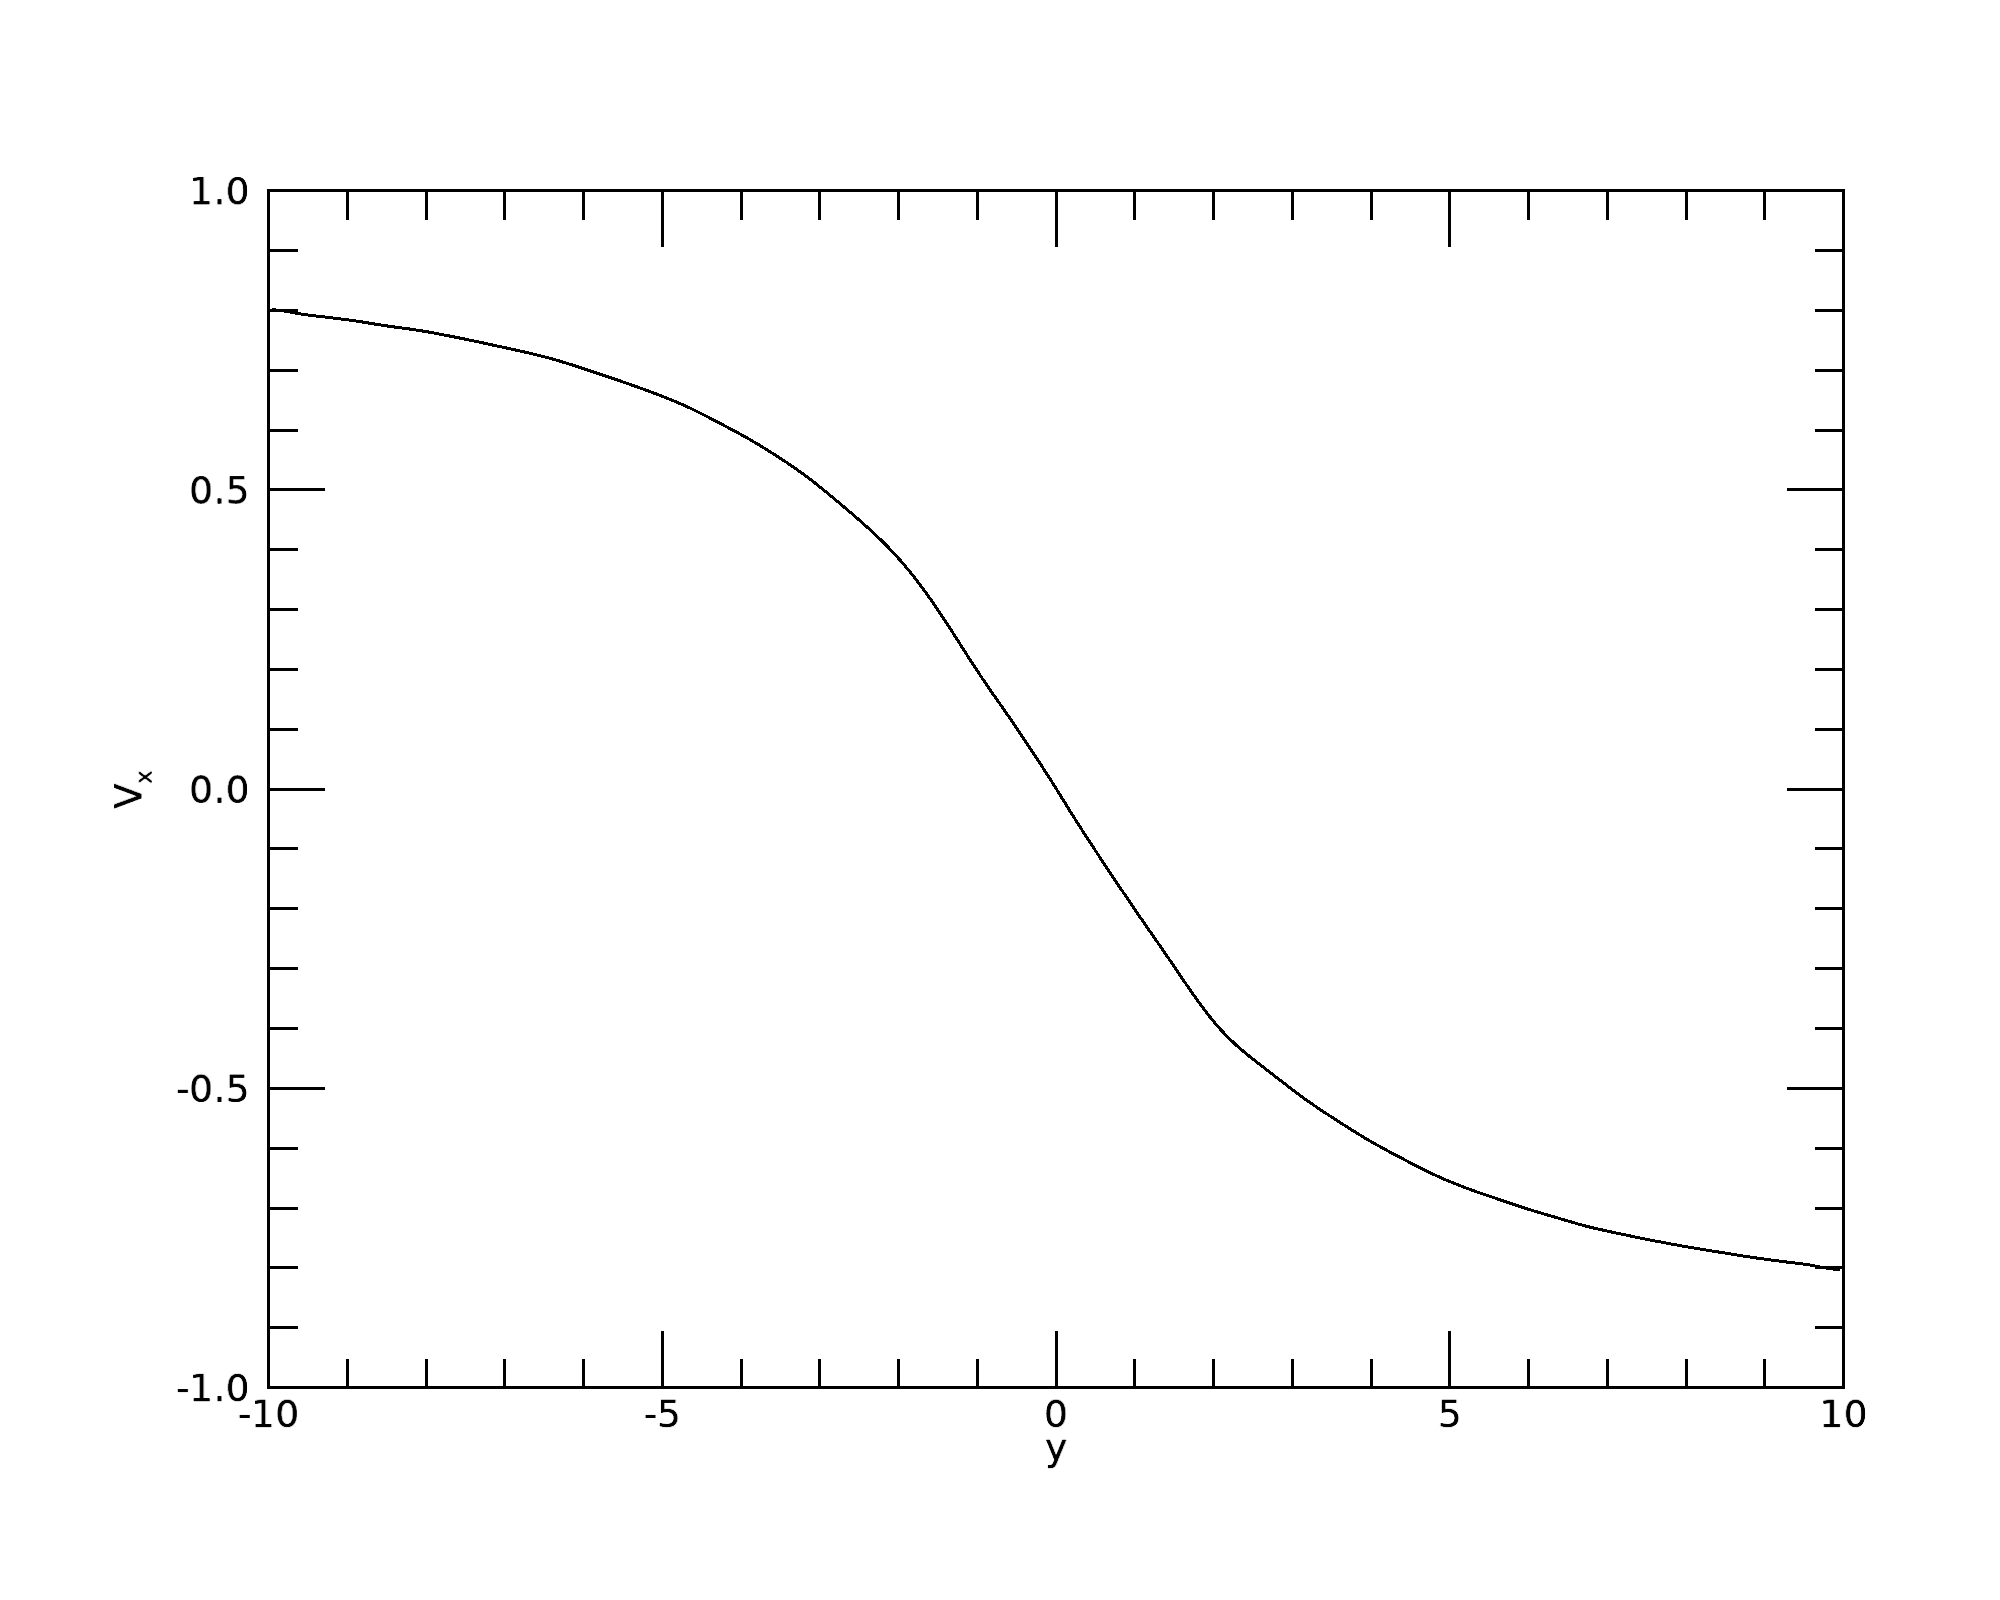

In [3]:
xpos1 = value_locate(x,max(x)/2)
pl = plot(y,reform(data[xpos1,*,7]),xtitle='y',ytitle='$V_x$')

フォントサイズ、フォント、プロットなどの見栄えを変えます

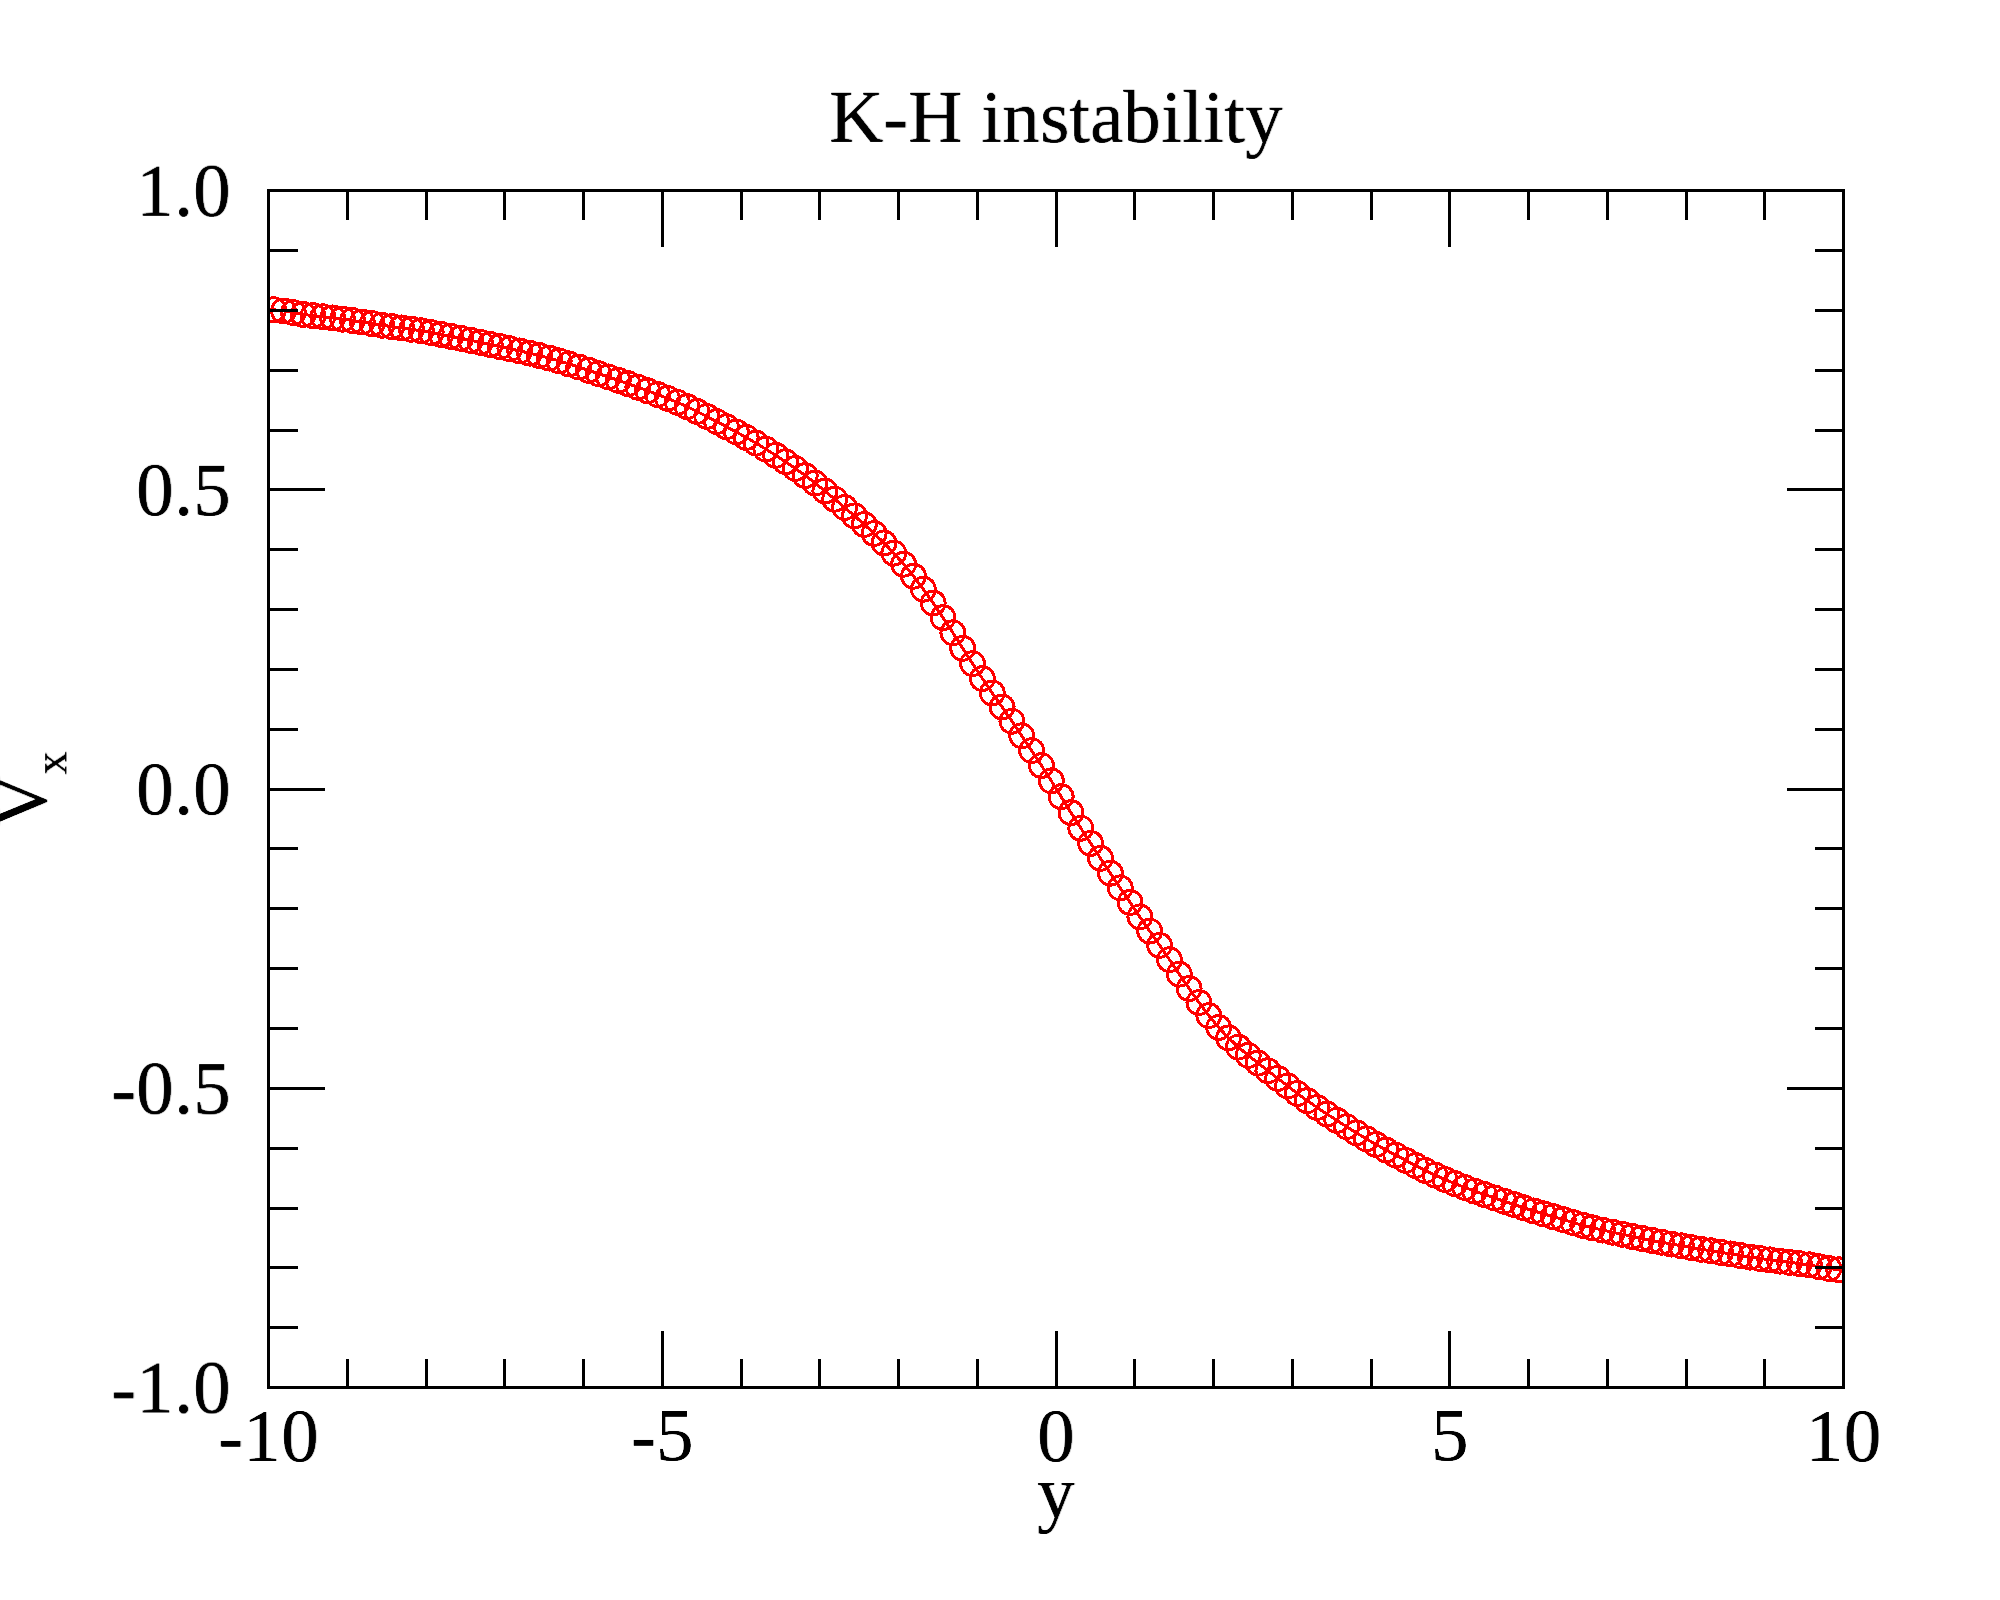

In [4]:
pl.title='K-H instability'
pl.font_size=18
pl.font_name='Times'
pl.symbol='o'
pl.color='red'

他の場所のプロットを重ね描きします

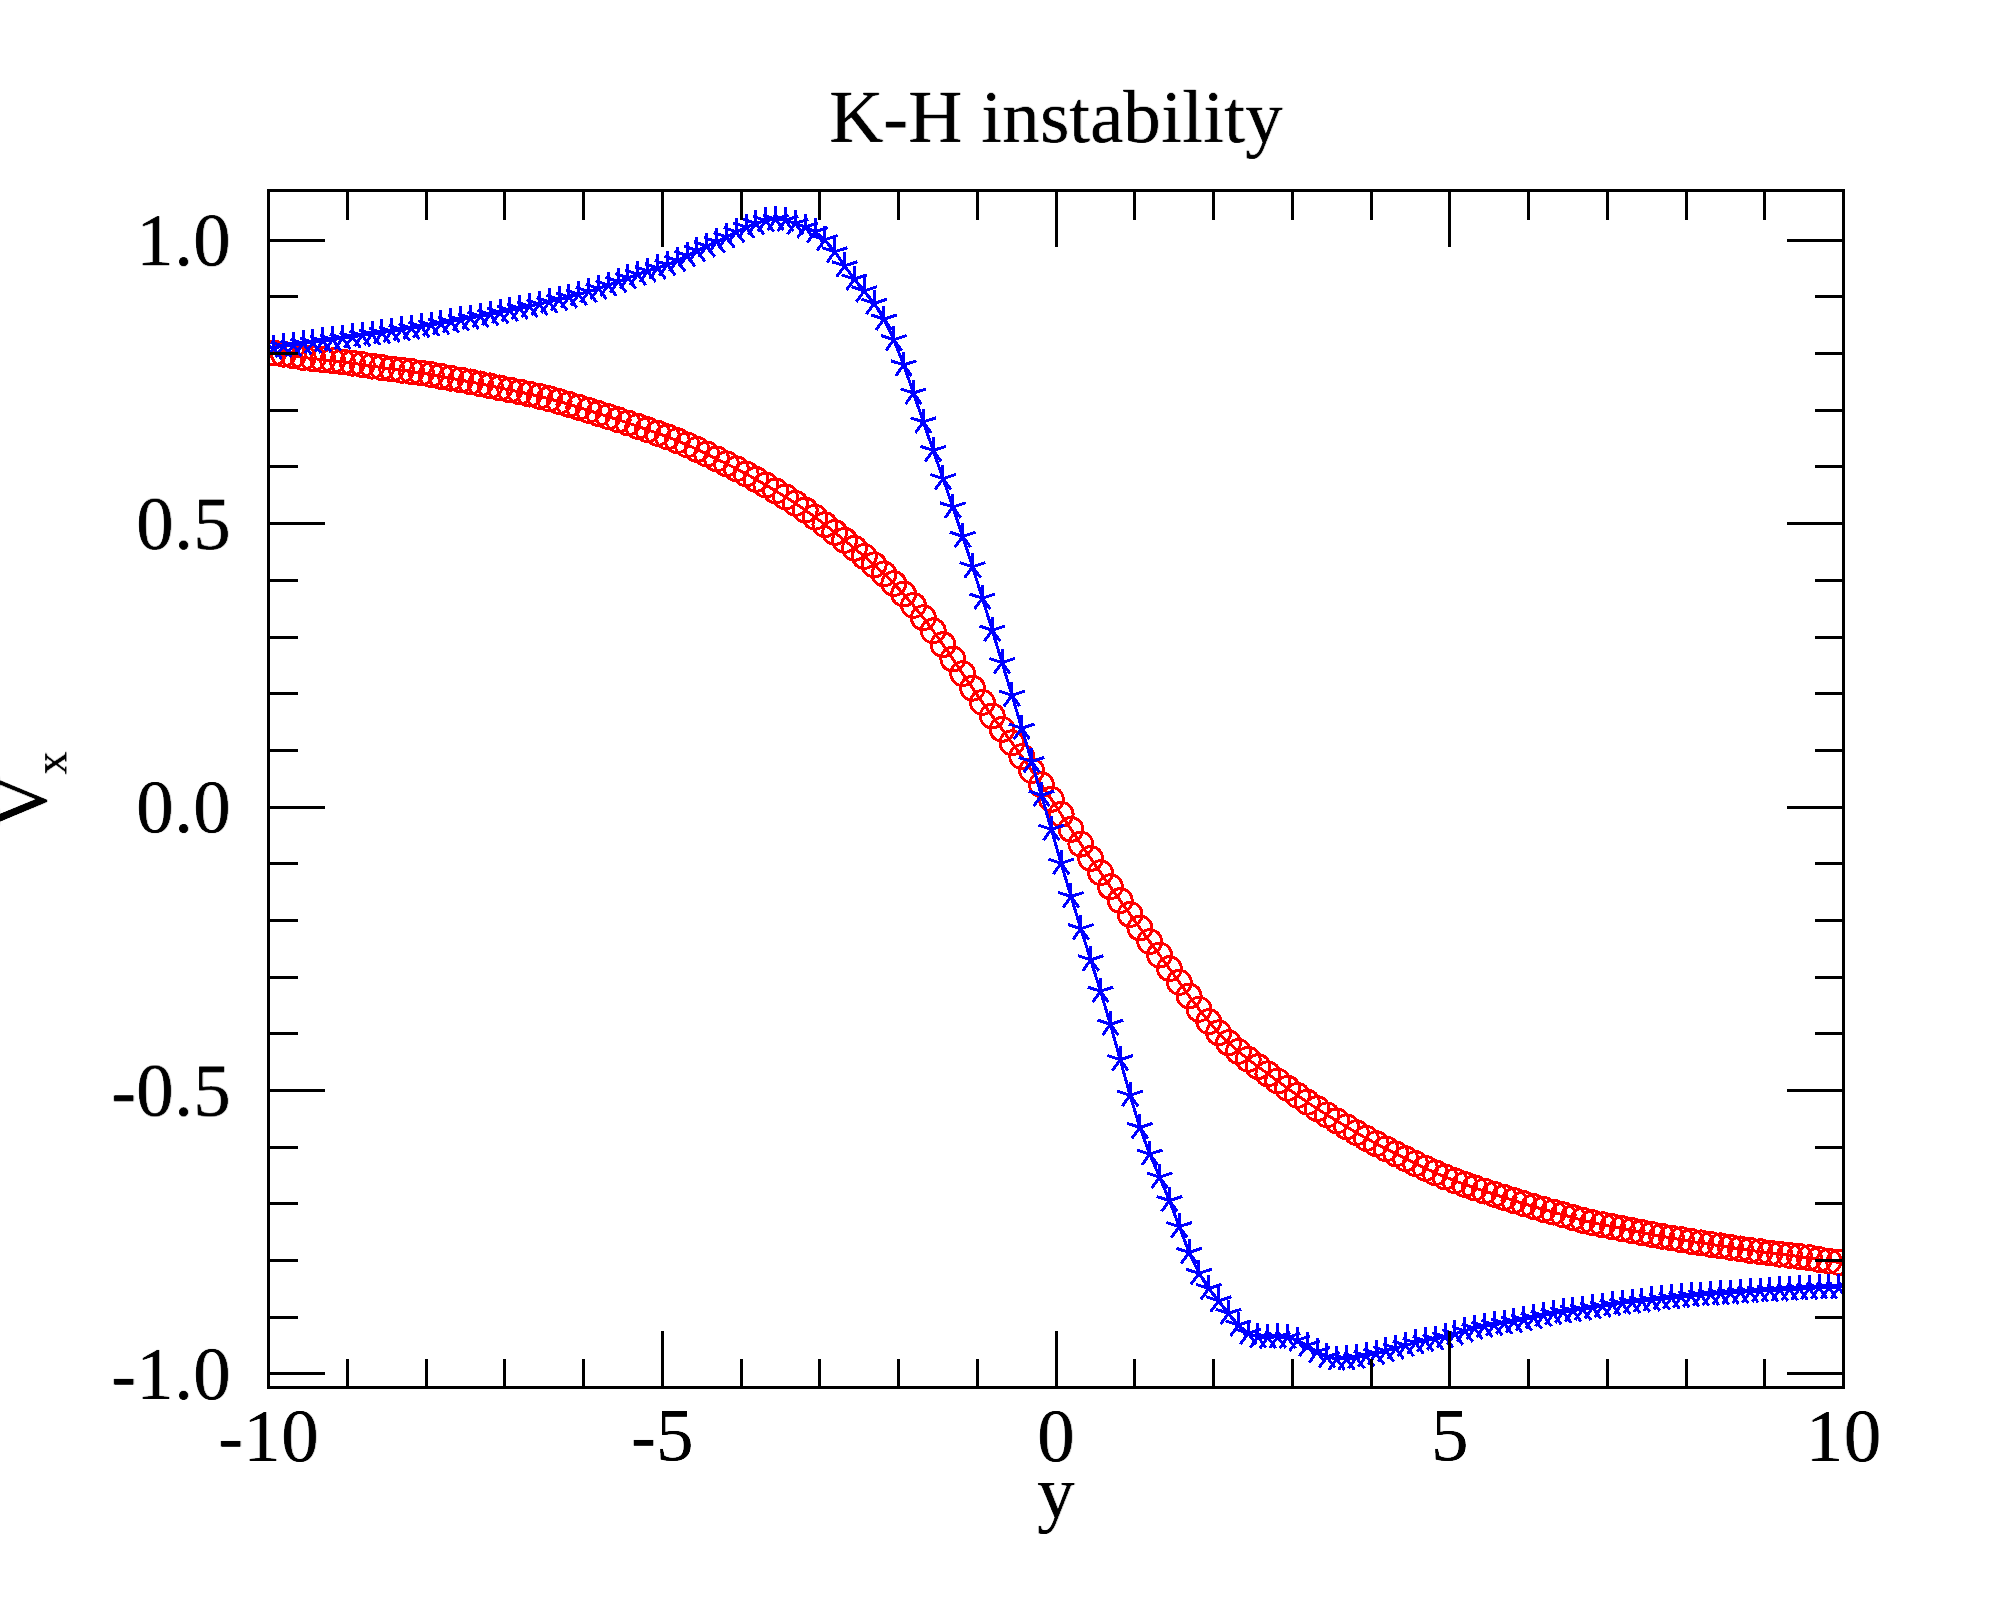

In [5]:
xpos2 = value_locate(x,max(x)/8)
pl2 = plot(y,reform(data[xpos2,*,7]),xtitle='y',ytitle='$V_x$',name='Vx at x=0.125Lx',color='blue',symbol='*',ystyle=3,over=pl)

## レジェンドを加える

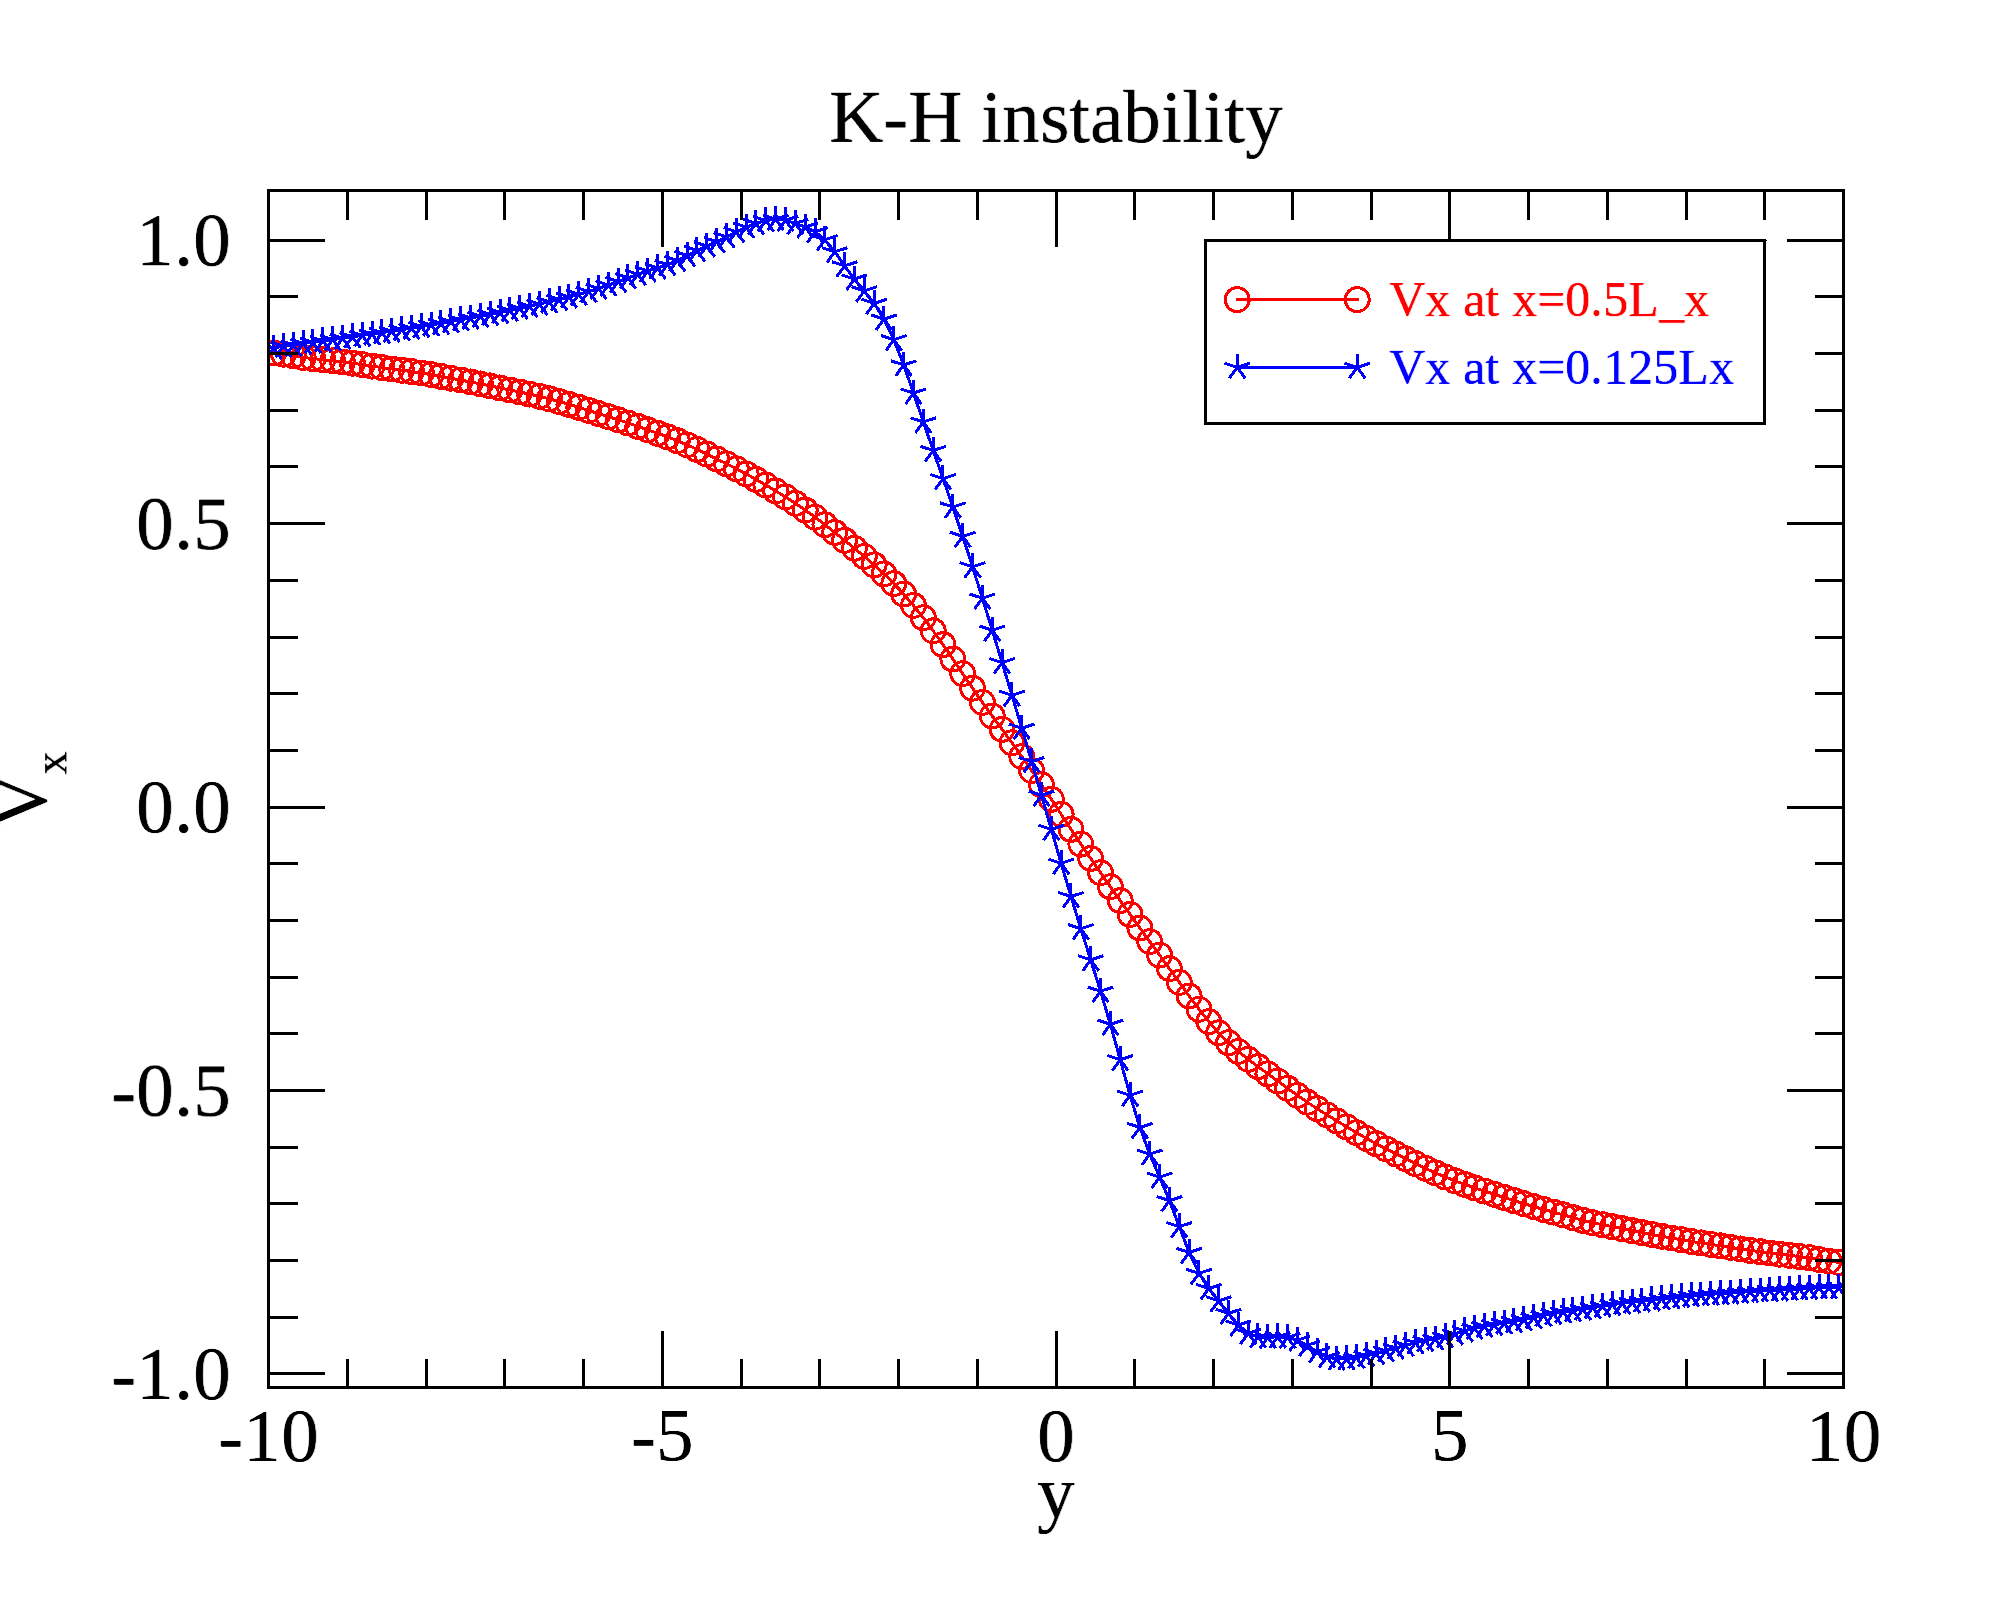

In [6]:
pl.name='Vx at x=0.5L_x'
leg = legend(target=[pl,pl2],font_name='Times',font_size=12,/auto,/data,position=[9.0,1.0])

# 2次元マップ

物理量の2次元空間プロファイルを表示する方法を紹介します。詳細については
```IDL
IDL> ?image
IDL> ?colorbar
```
でヘルプを調べてください。まずは圧力の表示

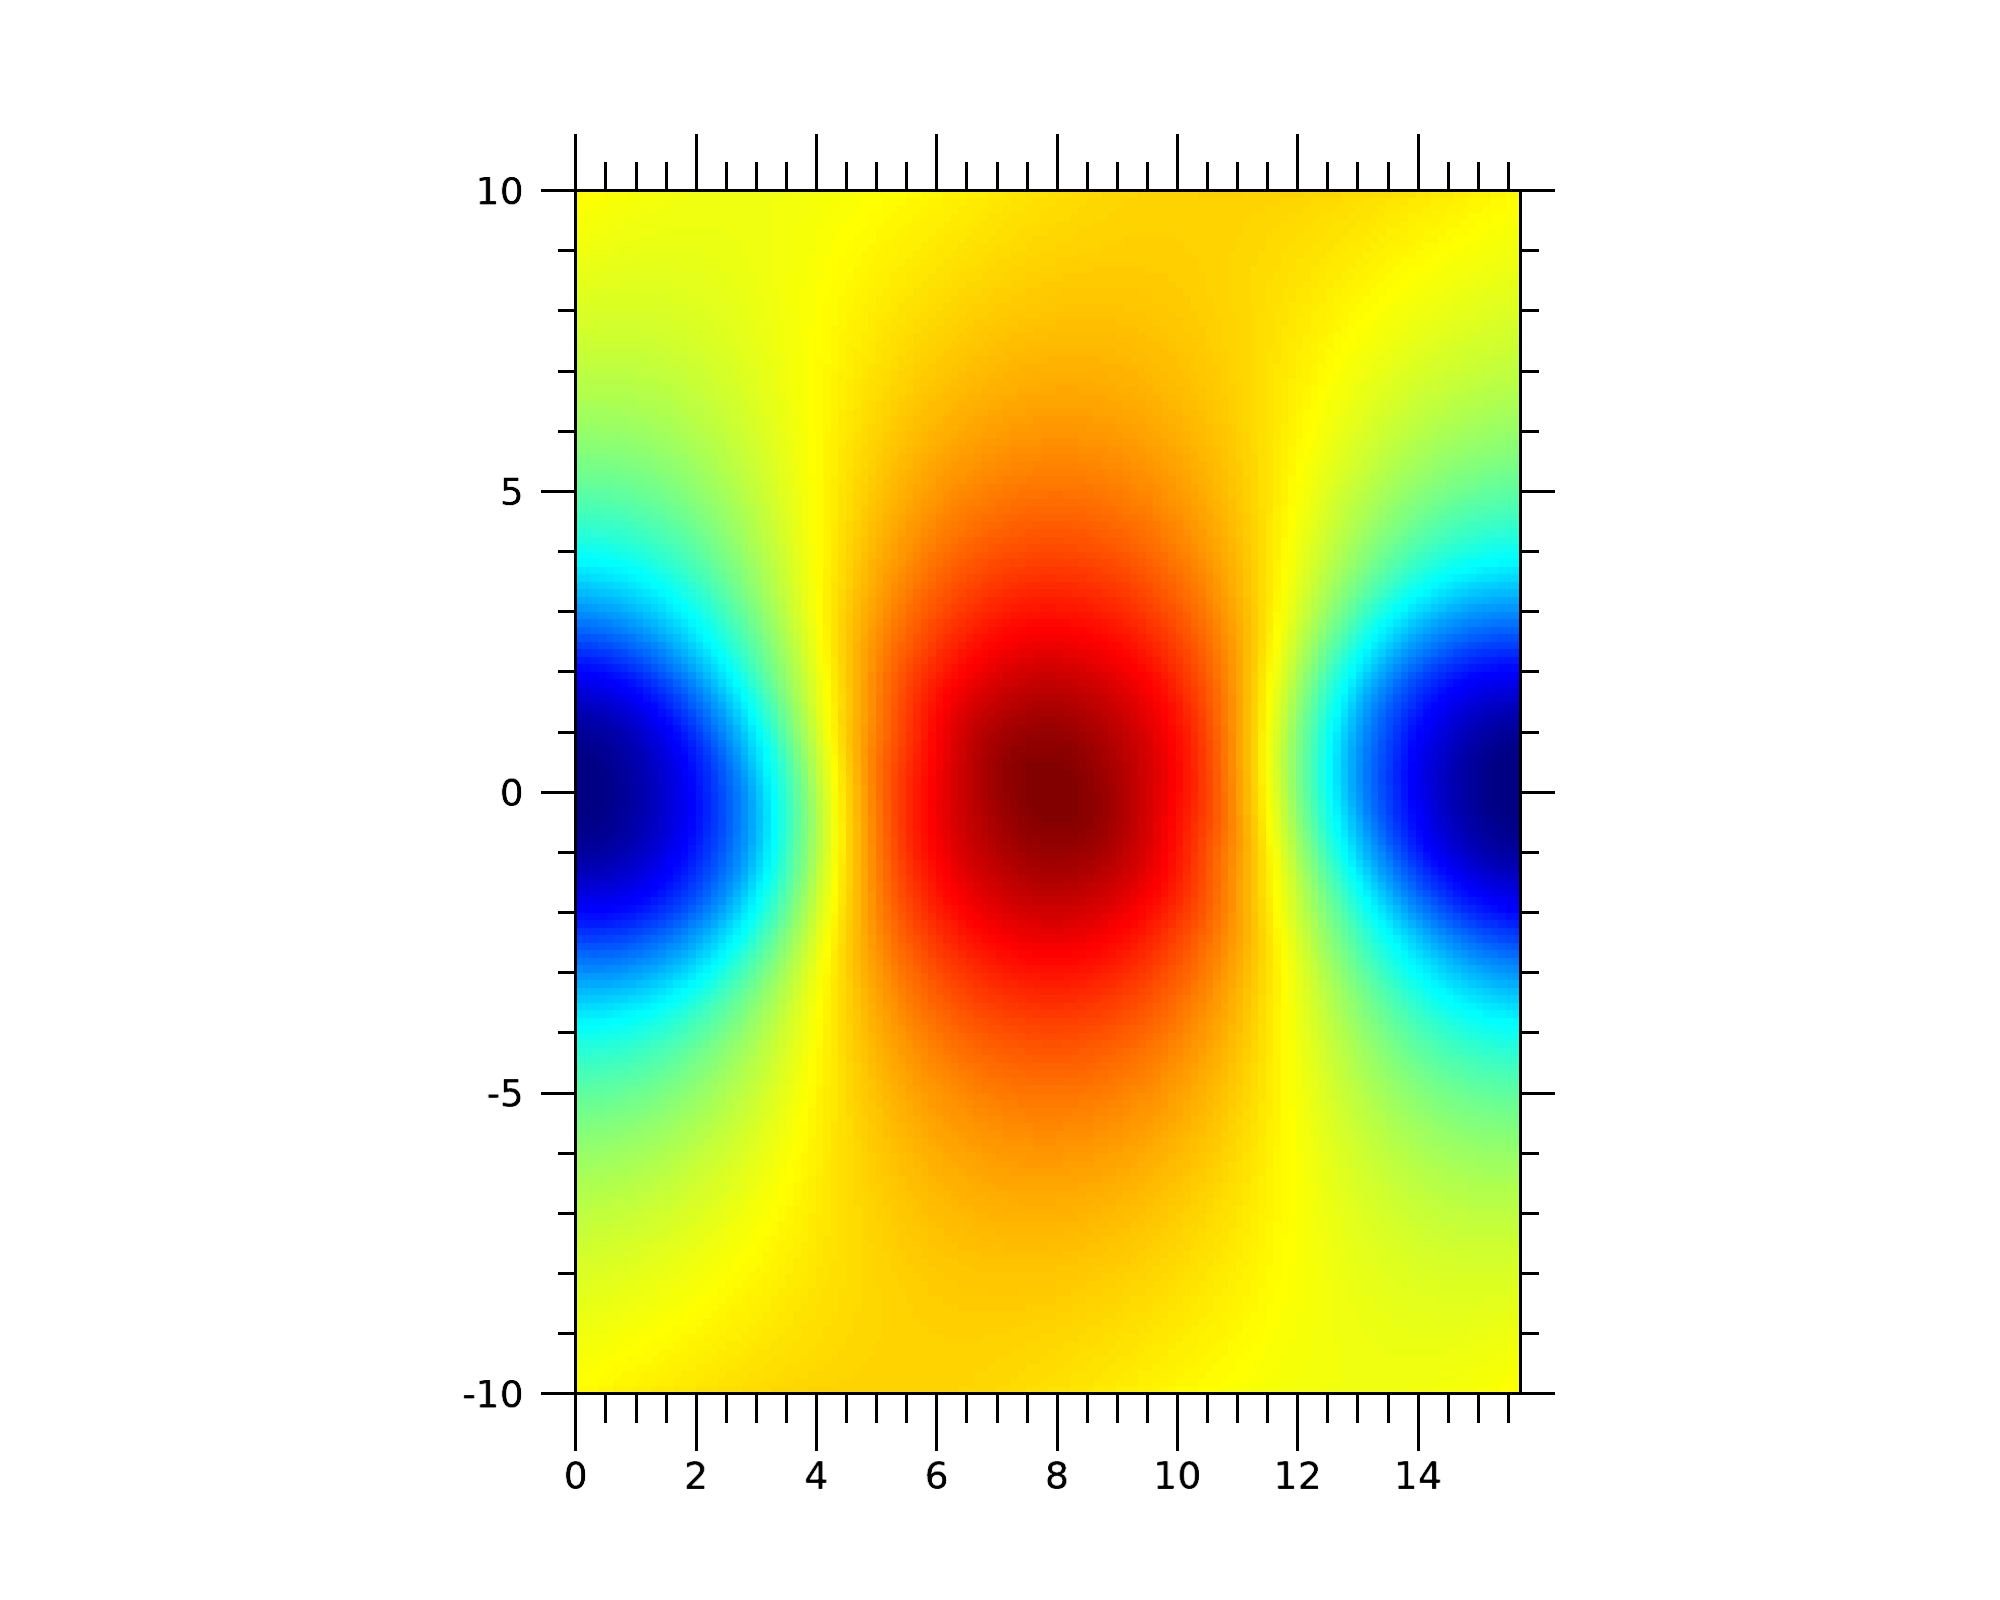

In [7]:
dx = abs(x[1]-x[0]) ;; 軸の位置の修正のため
dy = abs(y[1]-y[0]) ;; 軸の位置の修正のため
img = image(data[*,*,5],x-dx/2.,y-dy/2.,axis_style=2,xtickdir=1,ytickdir=1,rgb_table=33,layout=[1,1,1])

フォント、タイトルの変更、カラーバーの追加を行います。

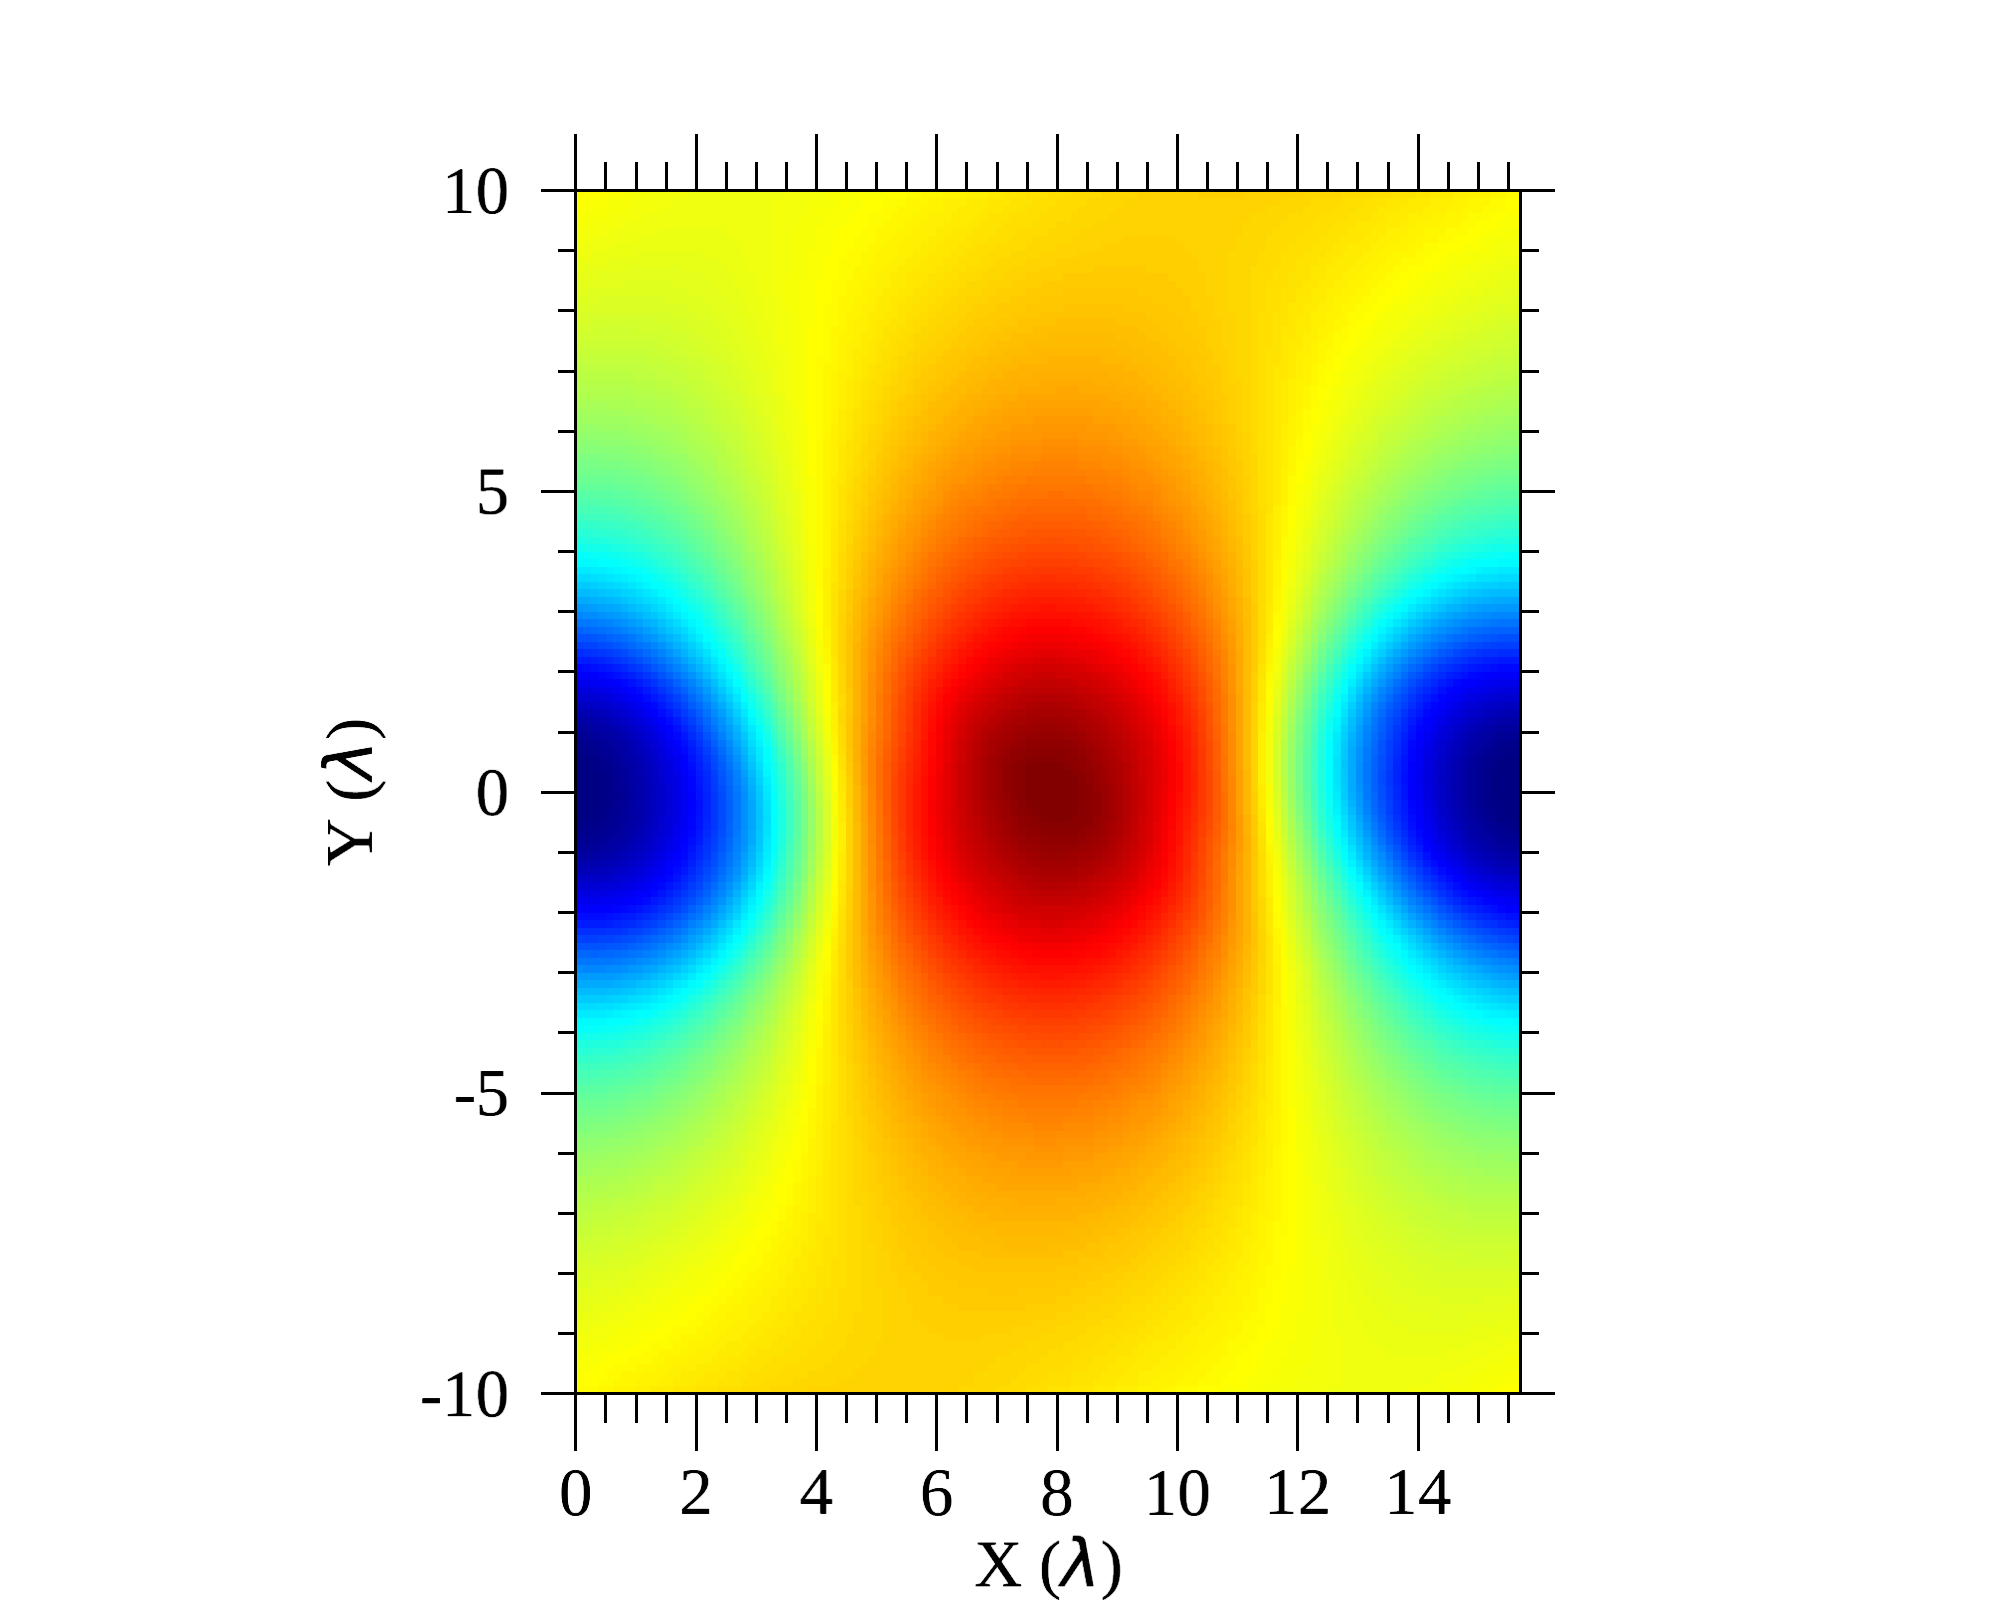

In [8]:
img.font_name='Times'
img.font_size='16'
img.xtitle='$X (\lambda)$'
img.ytitle='$Y (\lambda)$'
img.xstyle=1
img.ystyle=1

## カラーバー
カラーマップに対応したカラーバーを追加します。

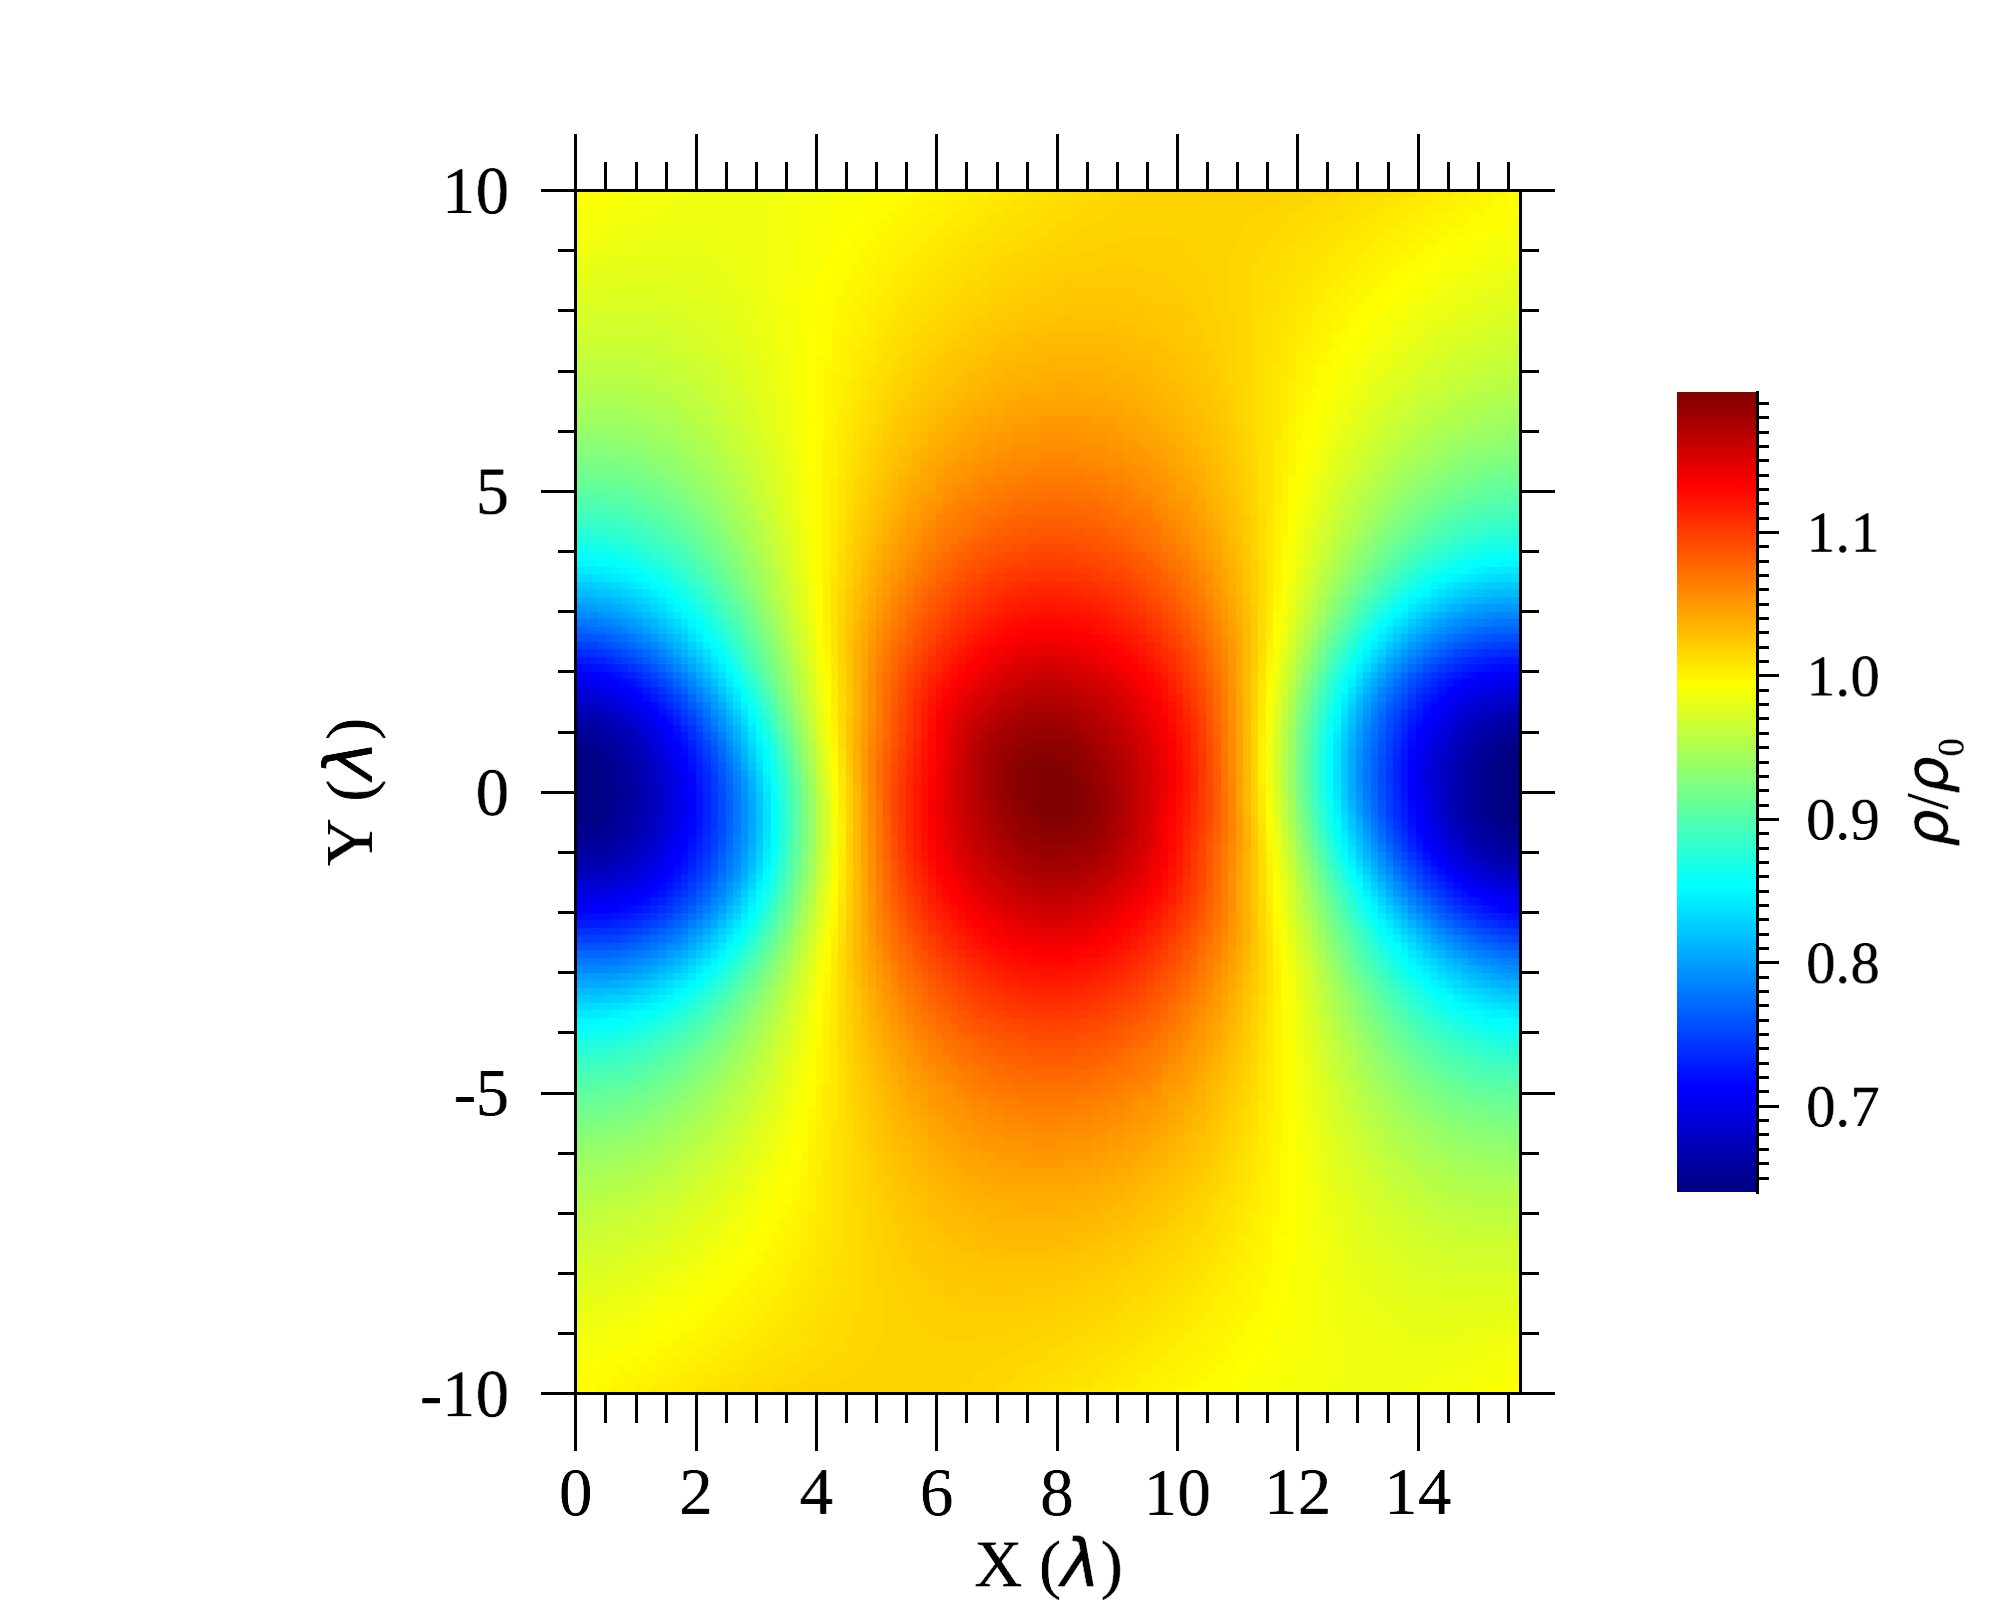

In [9]:
cb  = colorbar(target=img,orientation=1,textpos=1,font_name='Times',font_size=14,title='$\rho/\rho_0$')

カラースケール及び値のレンジははimageインスタンスのプロパティに自動的に対応します。例えばカラーテーブルを変えてみます。

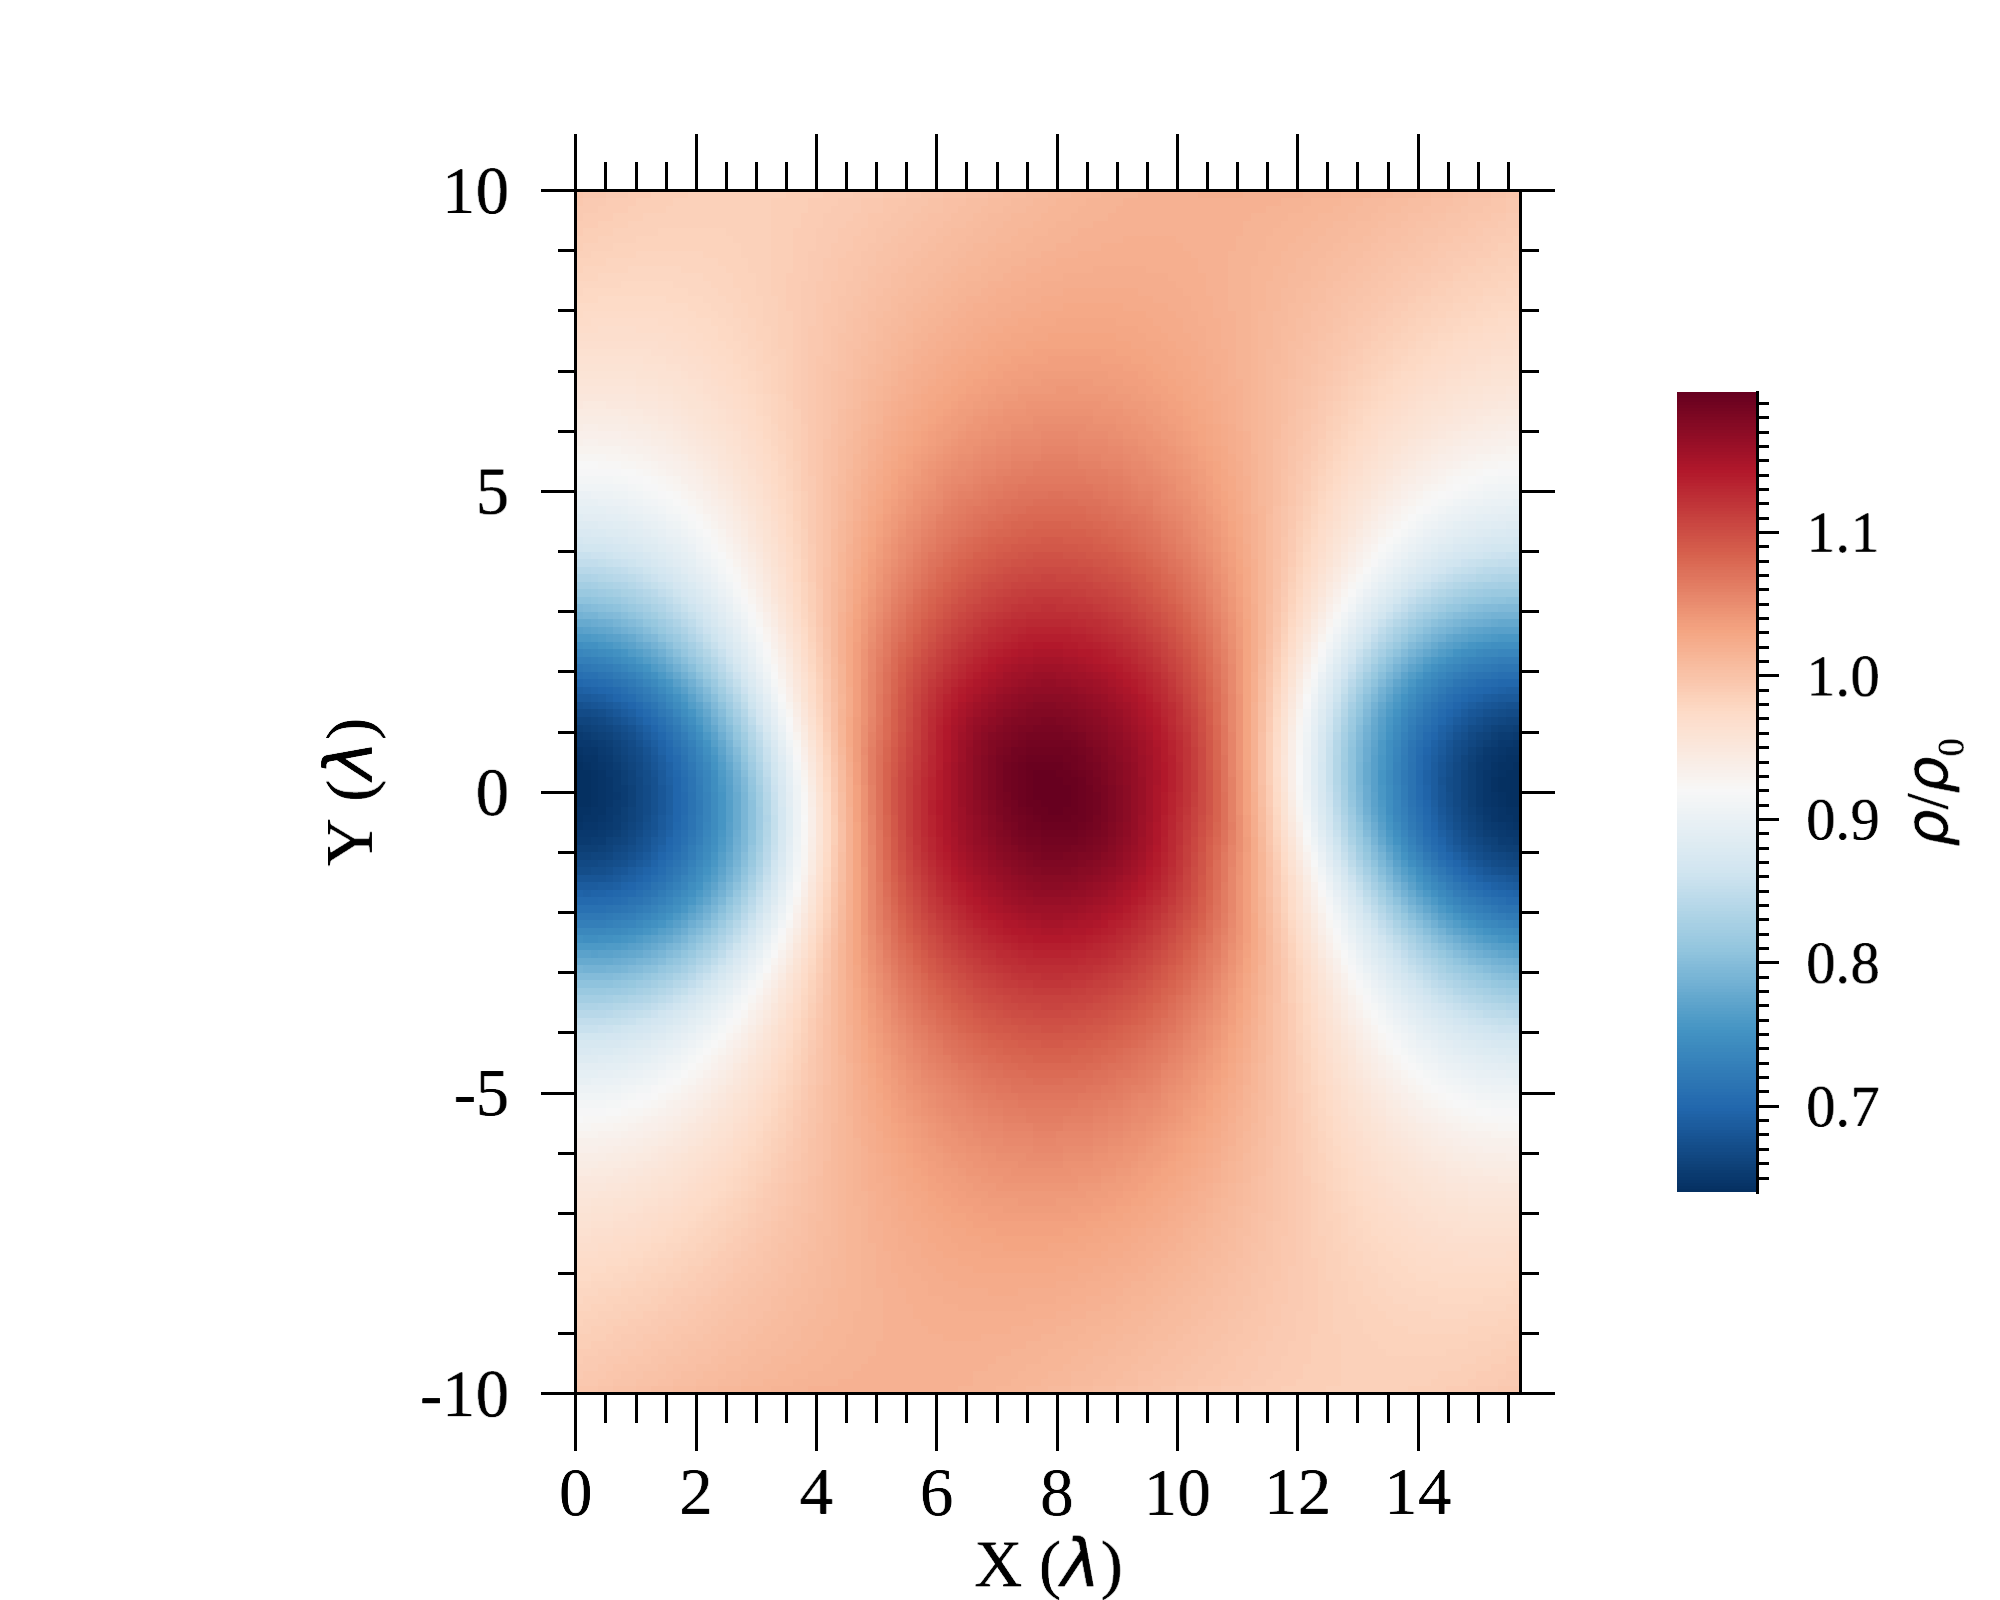

In [10]:
img.rgb_table=colortable(70,/reverse)

# ベクトル場の表示
## vector
ベクトル場を矢印で表現することも可能です。詳細は
```IDL
>IDL ?vector
```
を参考にしてください。上記で作成した2次元 カラー図 に速度場ベクトルを付け加える場合を例に示します。

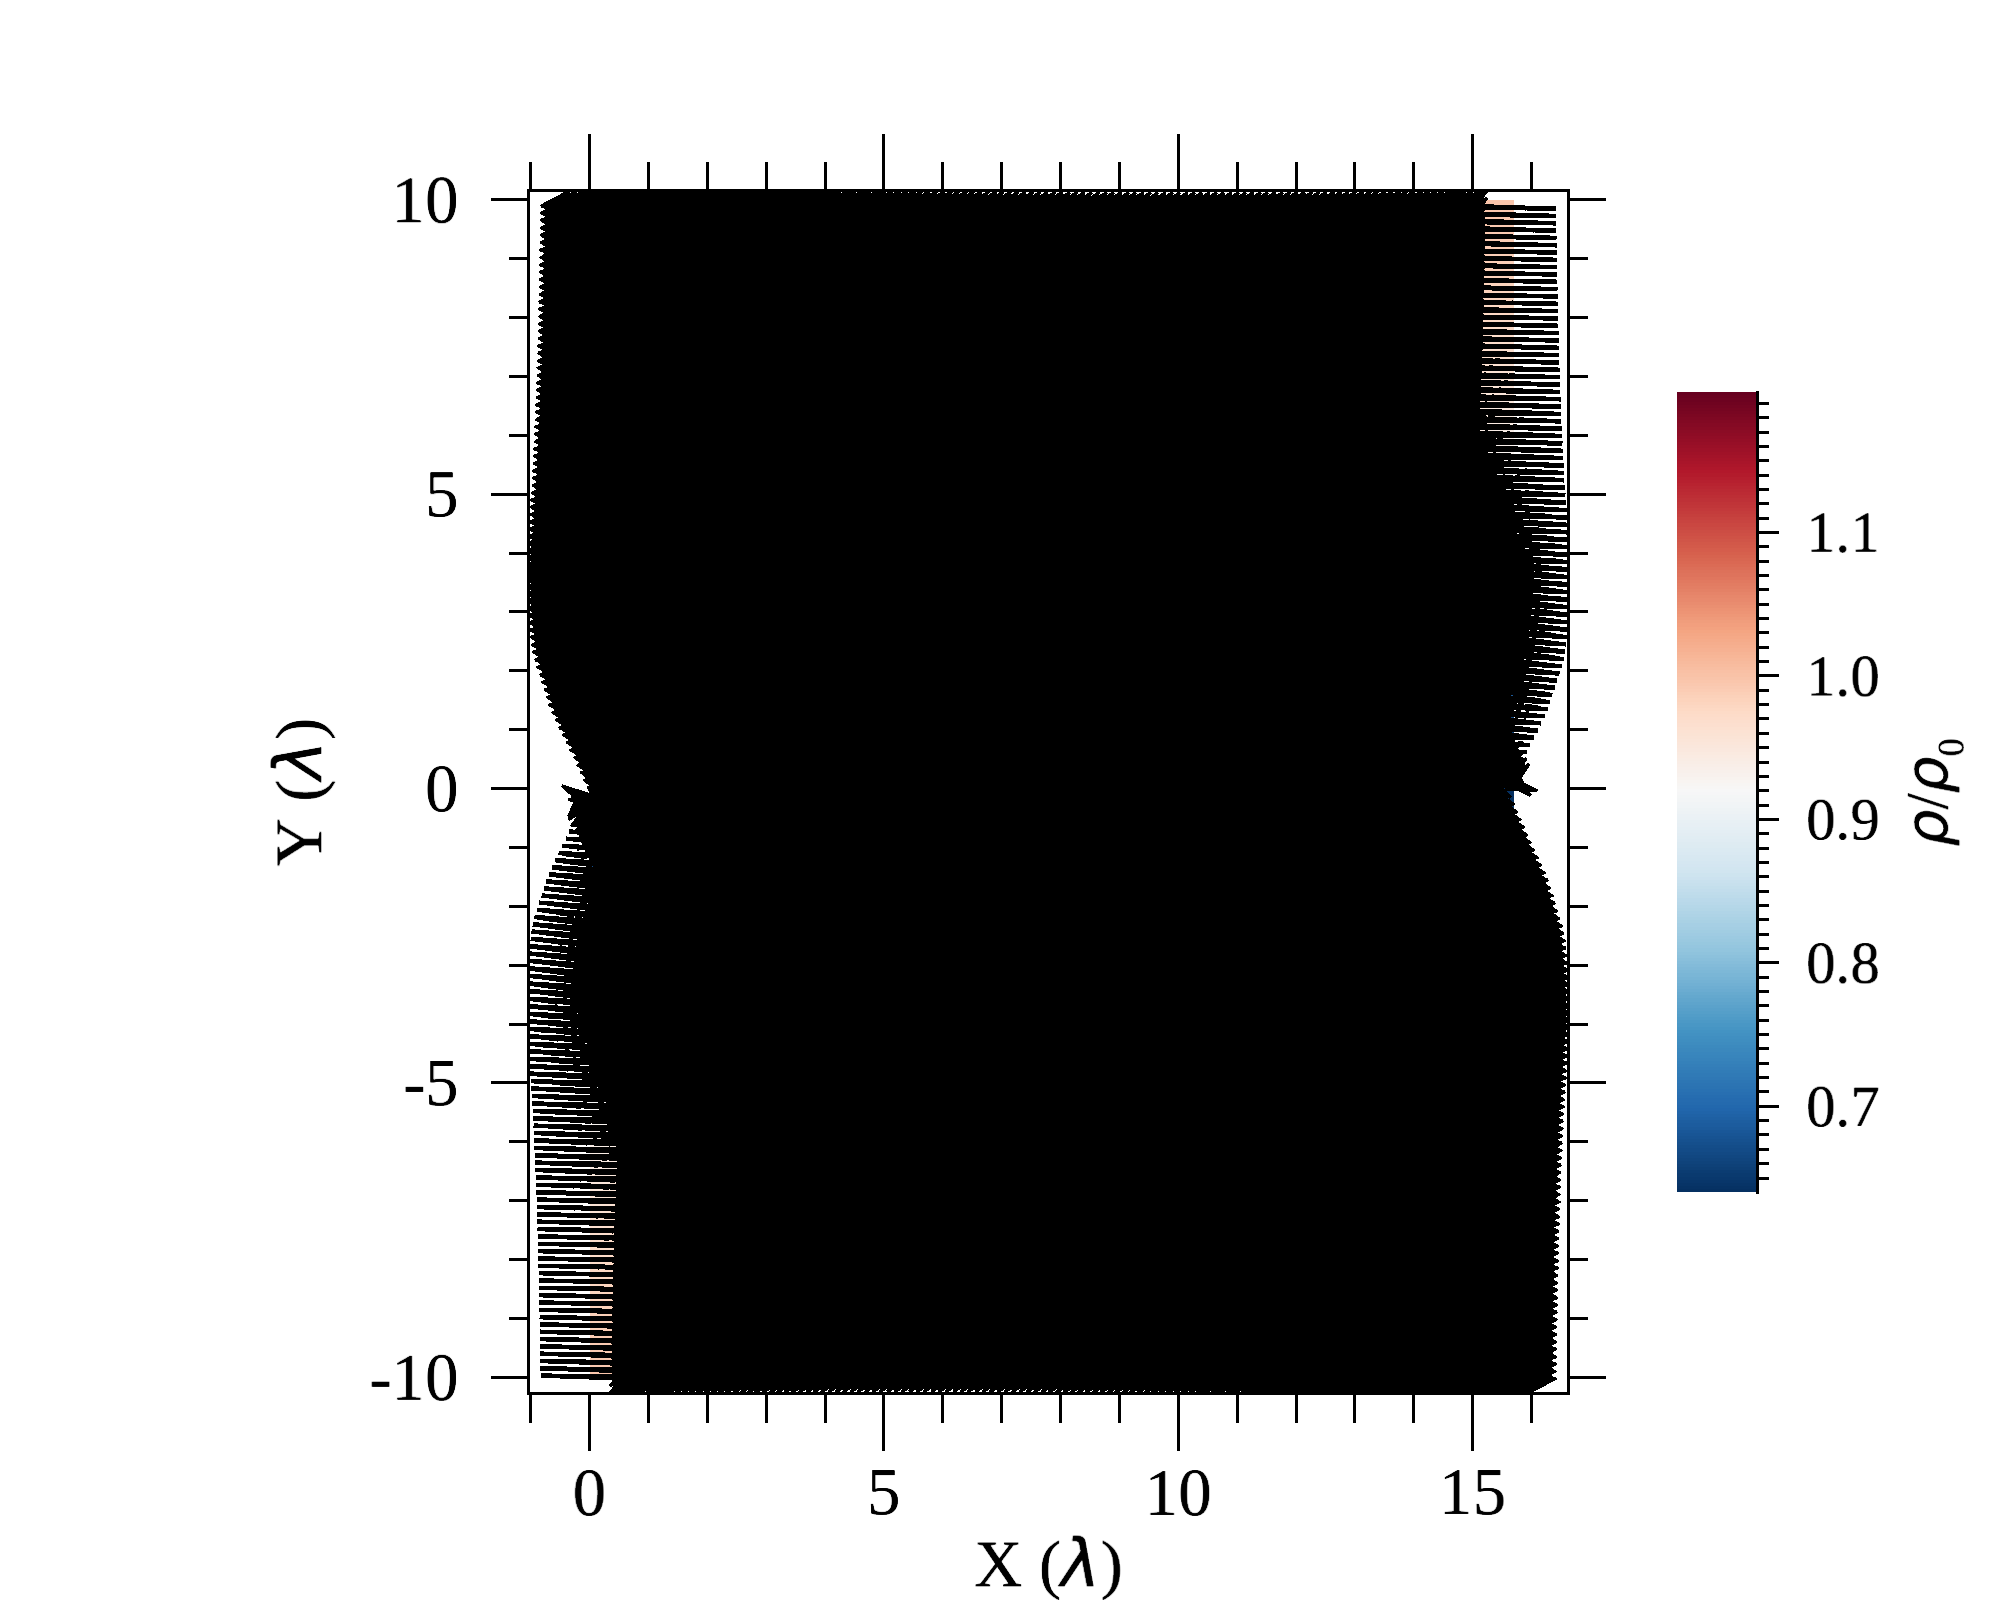

In [11]:
vct = vector(data[*,*,7],data[*,*,8],x-dx/2.,y-dy/2.,overplot=img)

しかし、そのままだと全ての情報を矢印で描くことになってしまうので、サンプリングして描画するように修正する。

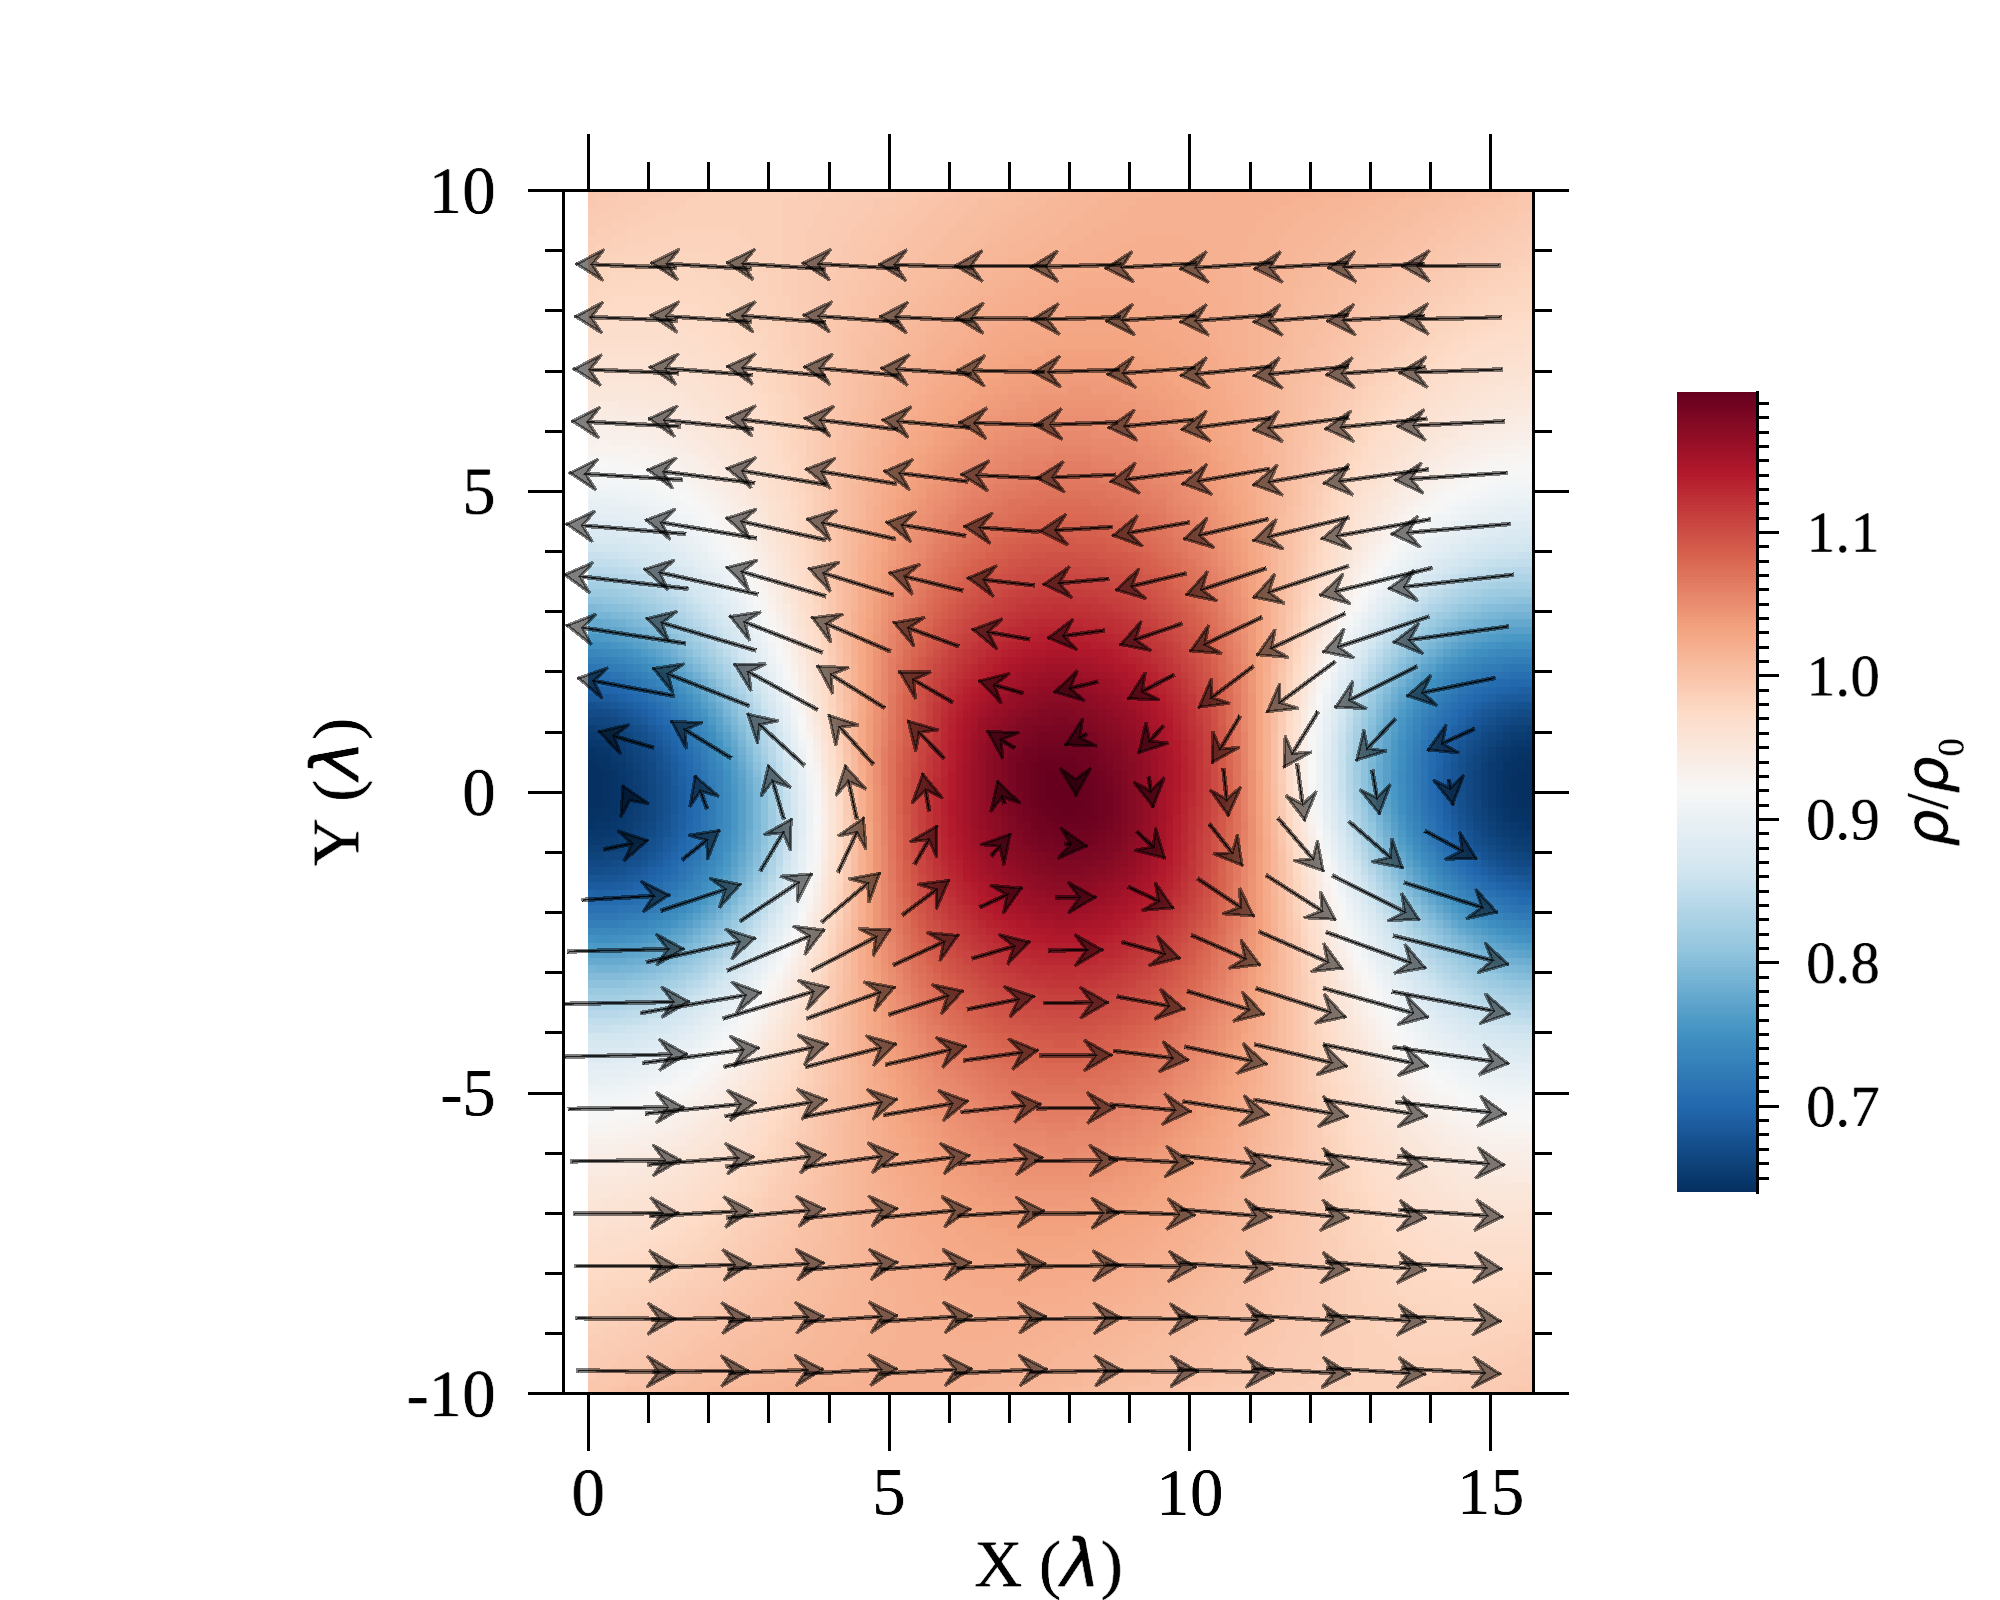

In [12]:
vct.x_subsample = 10
vct.y_subsample = 7
vct.transparency = 50 ;; ついでに矢印を透過（50%）
vct.xstyle=1
vct.ystyle=1

## streamline
矢印だとうまく表現できない場合もあるので、別の方法を紹介します。
```IDL
>IDL ?streamline
```
を参考にしてください。

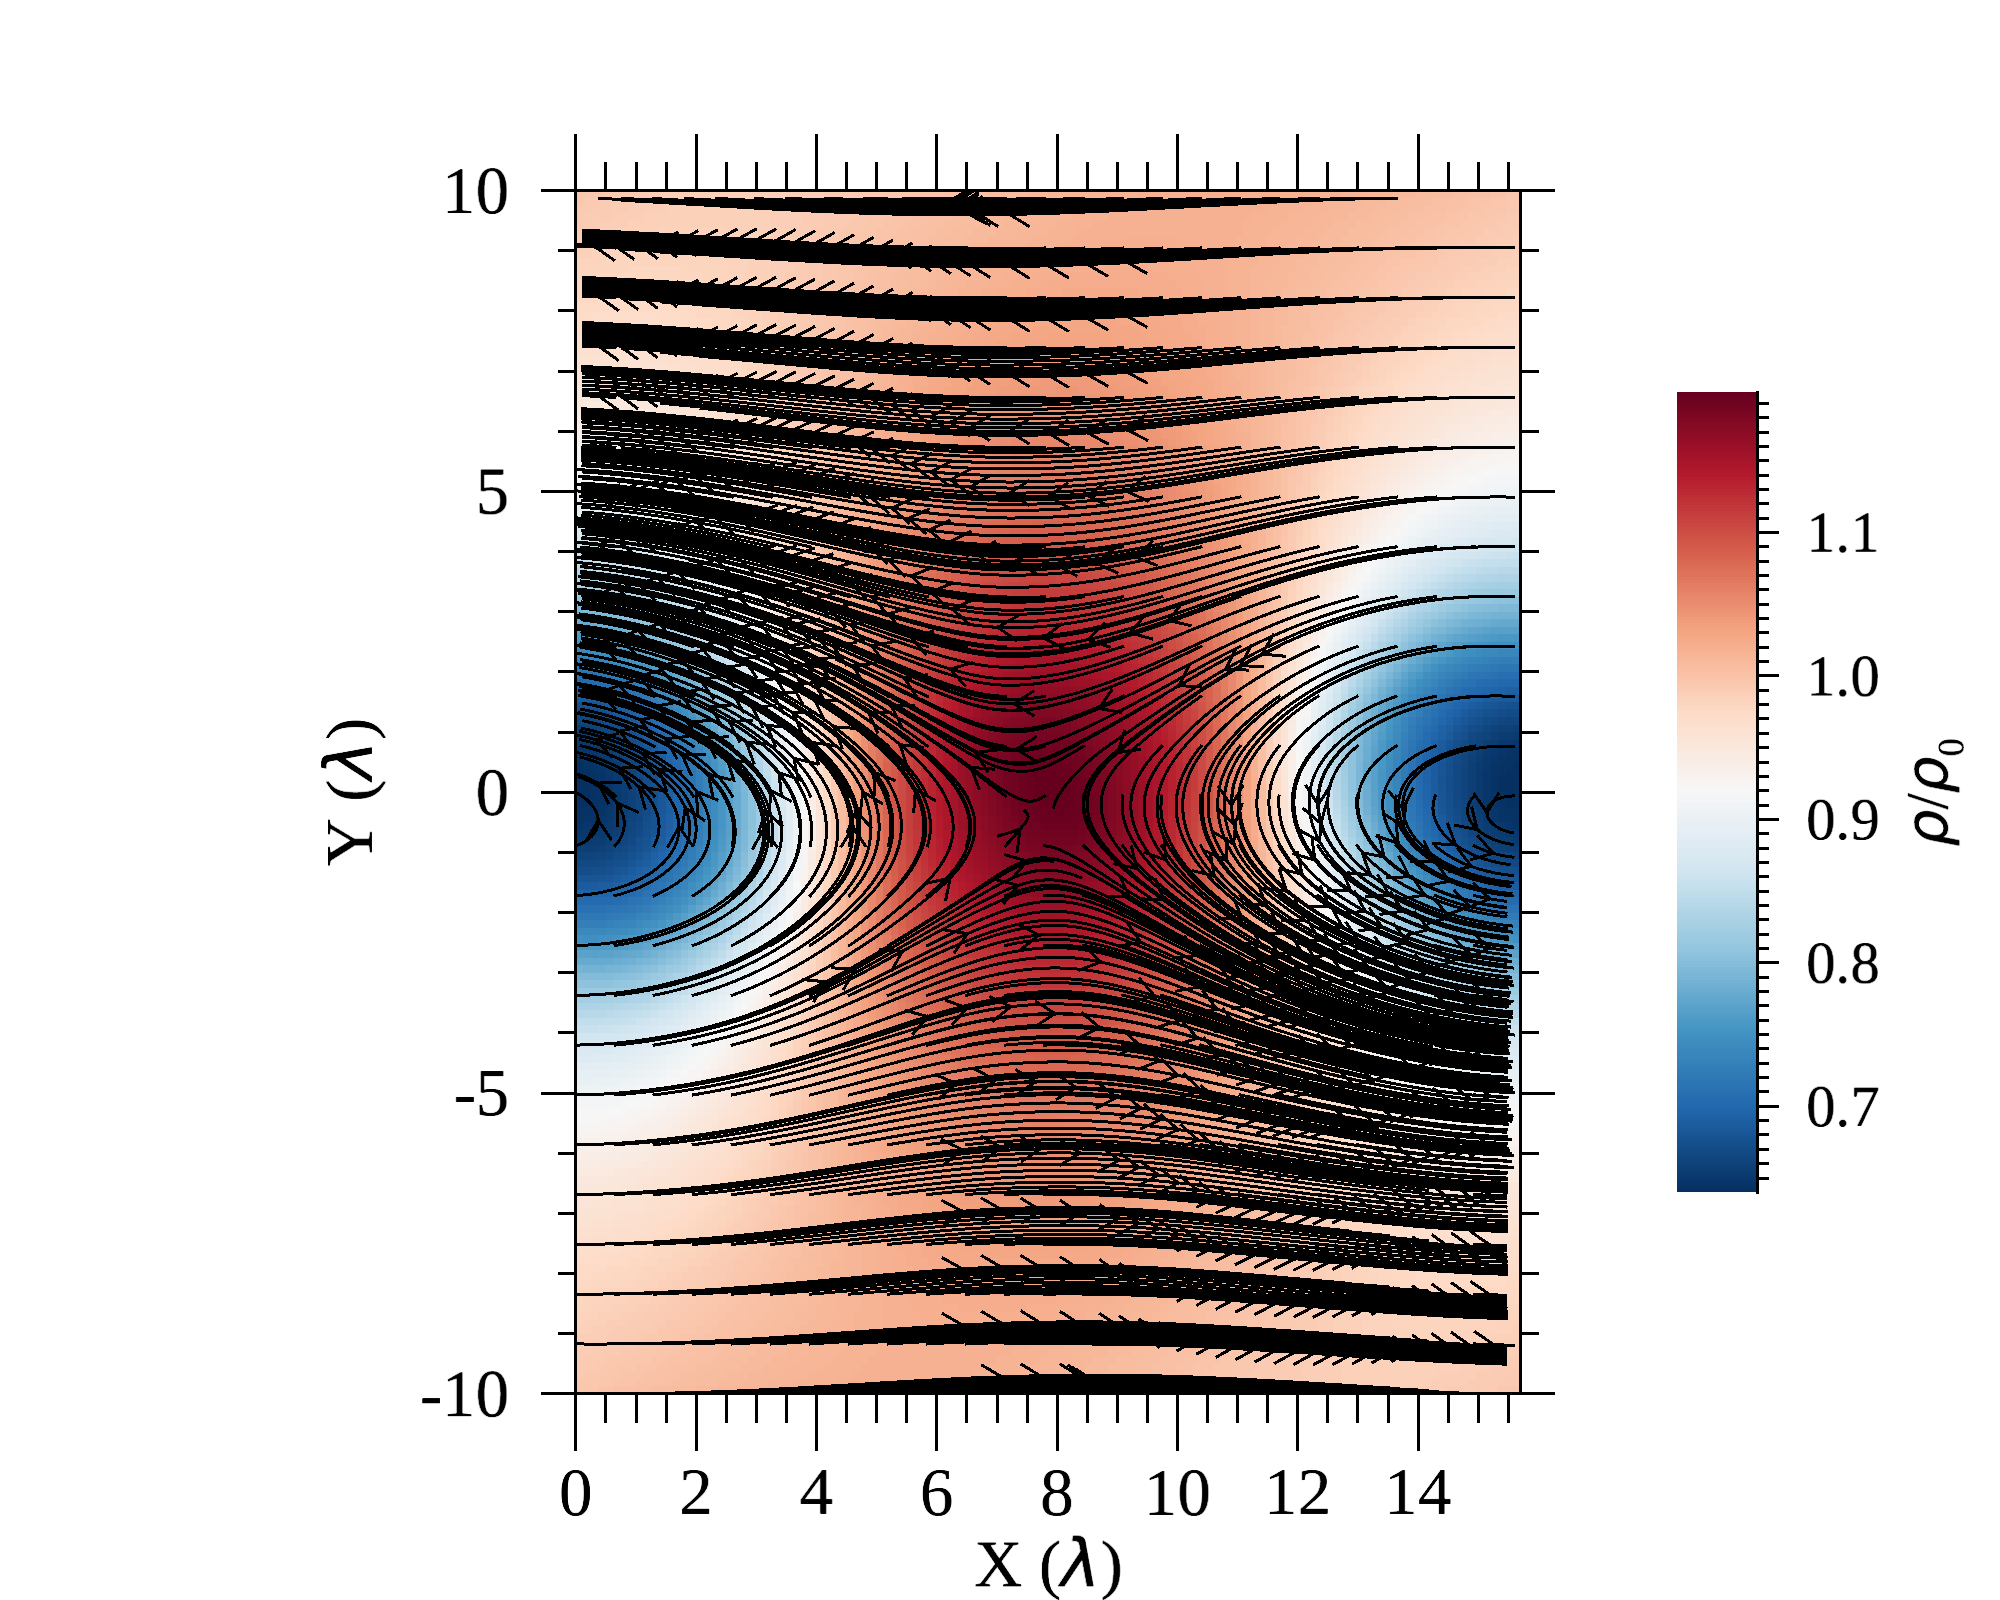

In [13]:
vct.delete
str = streamline(data[*,*,7],data[*,*,8],x-dx/2.,y-dy/2.,overplot=img)

やはり線が多すぎるので調整します。

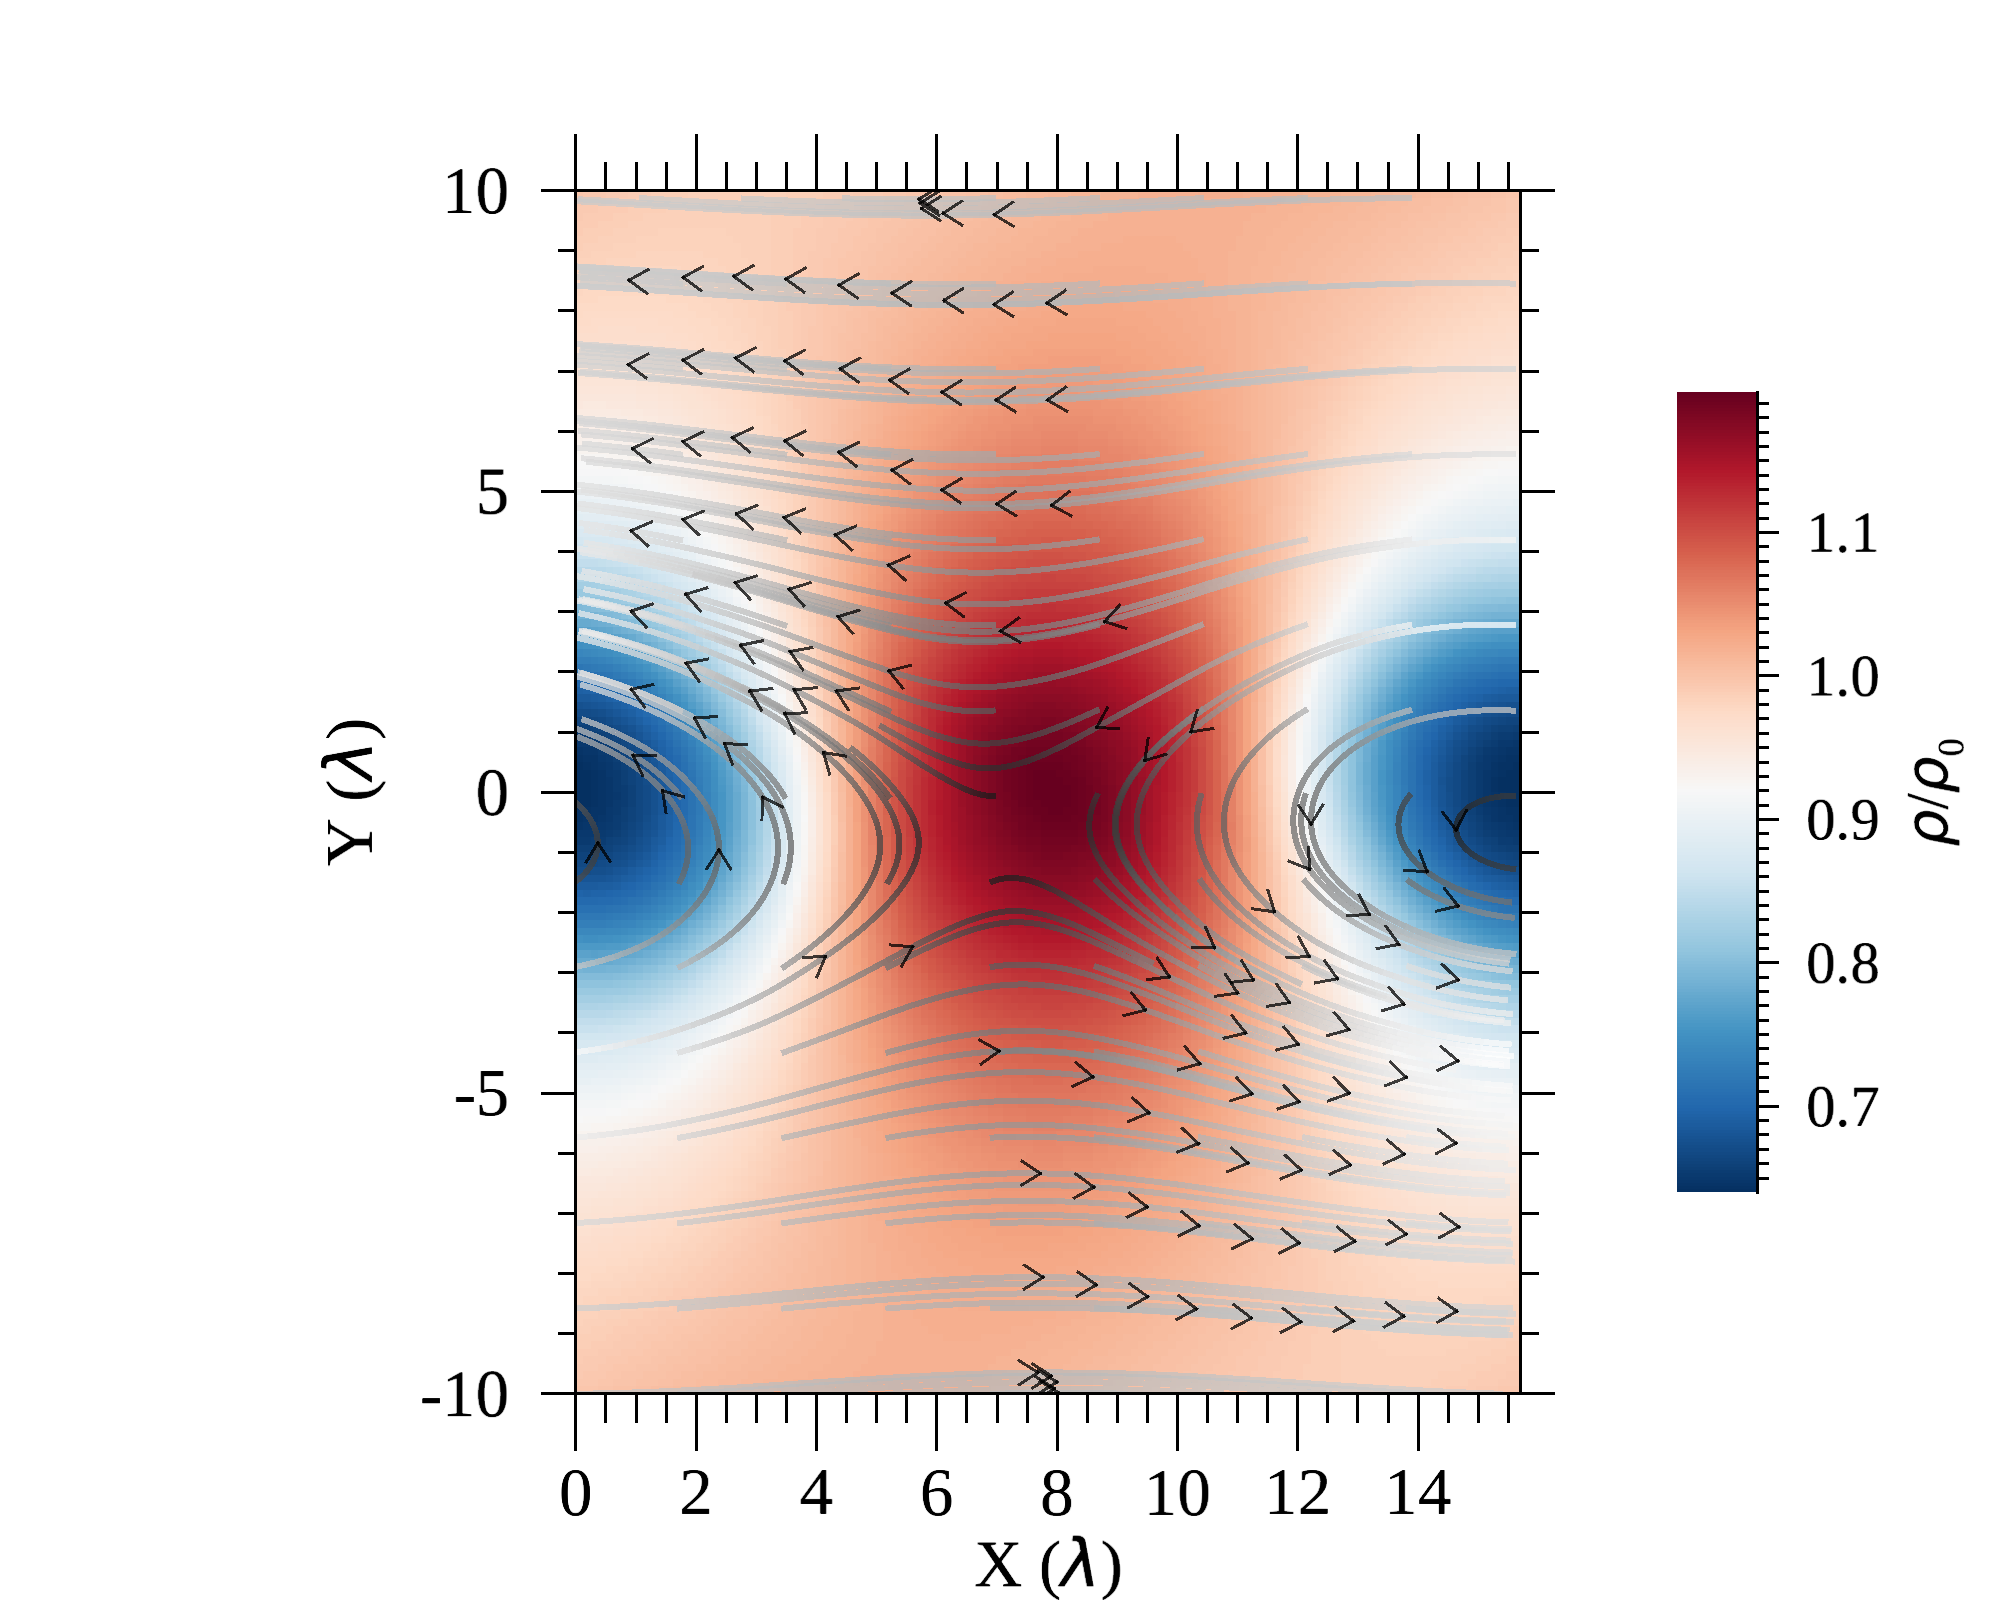

In [14]:
str.x_streamparticles=10
str.y_streamparticles=15
str.auto_color=1
str.transparency=25
str.thick=2

# 等高線
磁力線を描く（ベクトルポテンシャルの等高線）ためには、等高線を図示するのが便利です。例えば、上記で作成した2次元 カラー図 に質量密度の等高線を描き加える（この例では圧力分布とほぼ同じ）場合を以下で示します。詳細は
```IDL
IDL> ?contour
```
を参考にしてください。

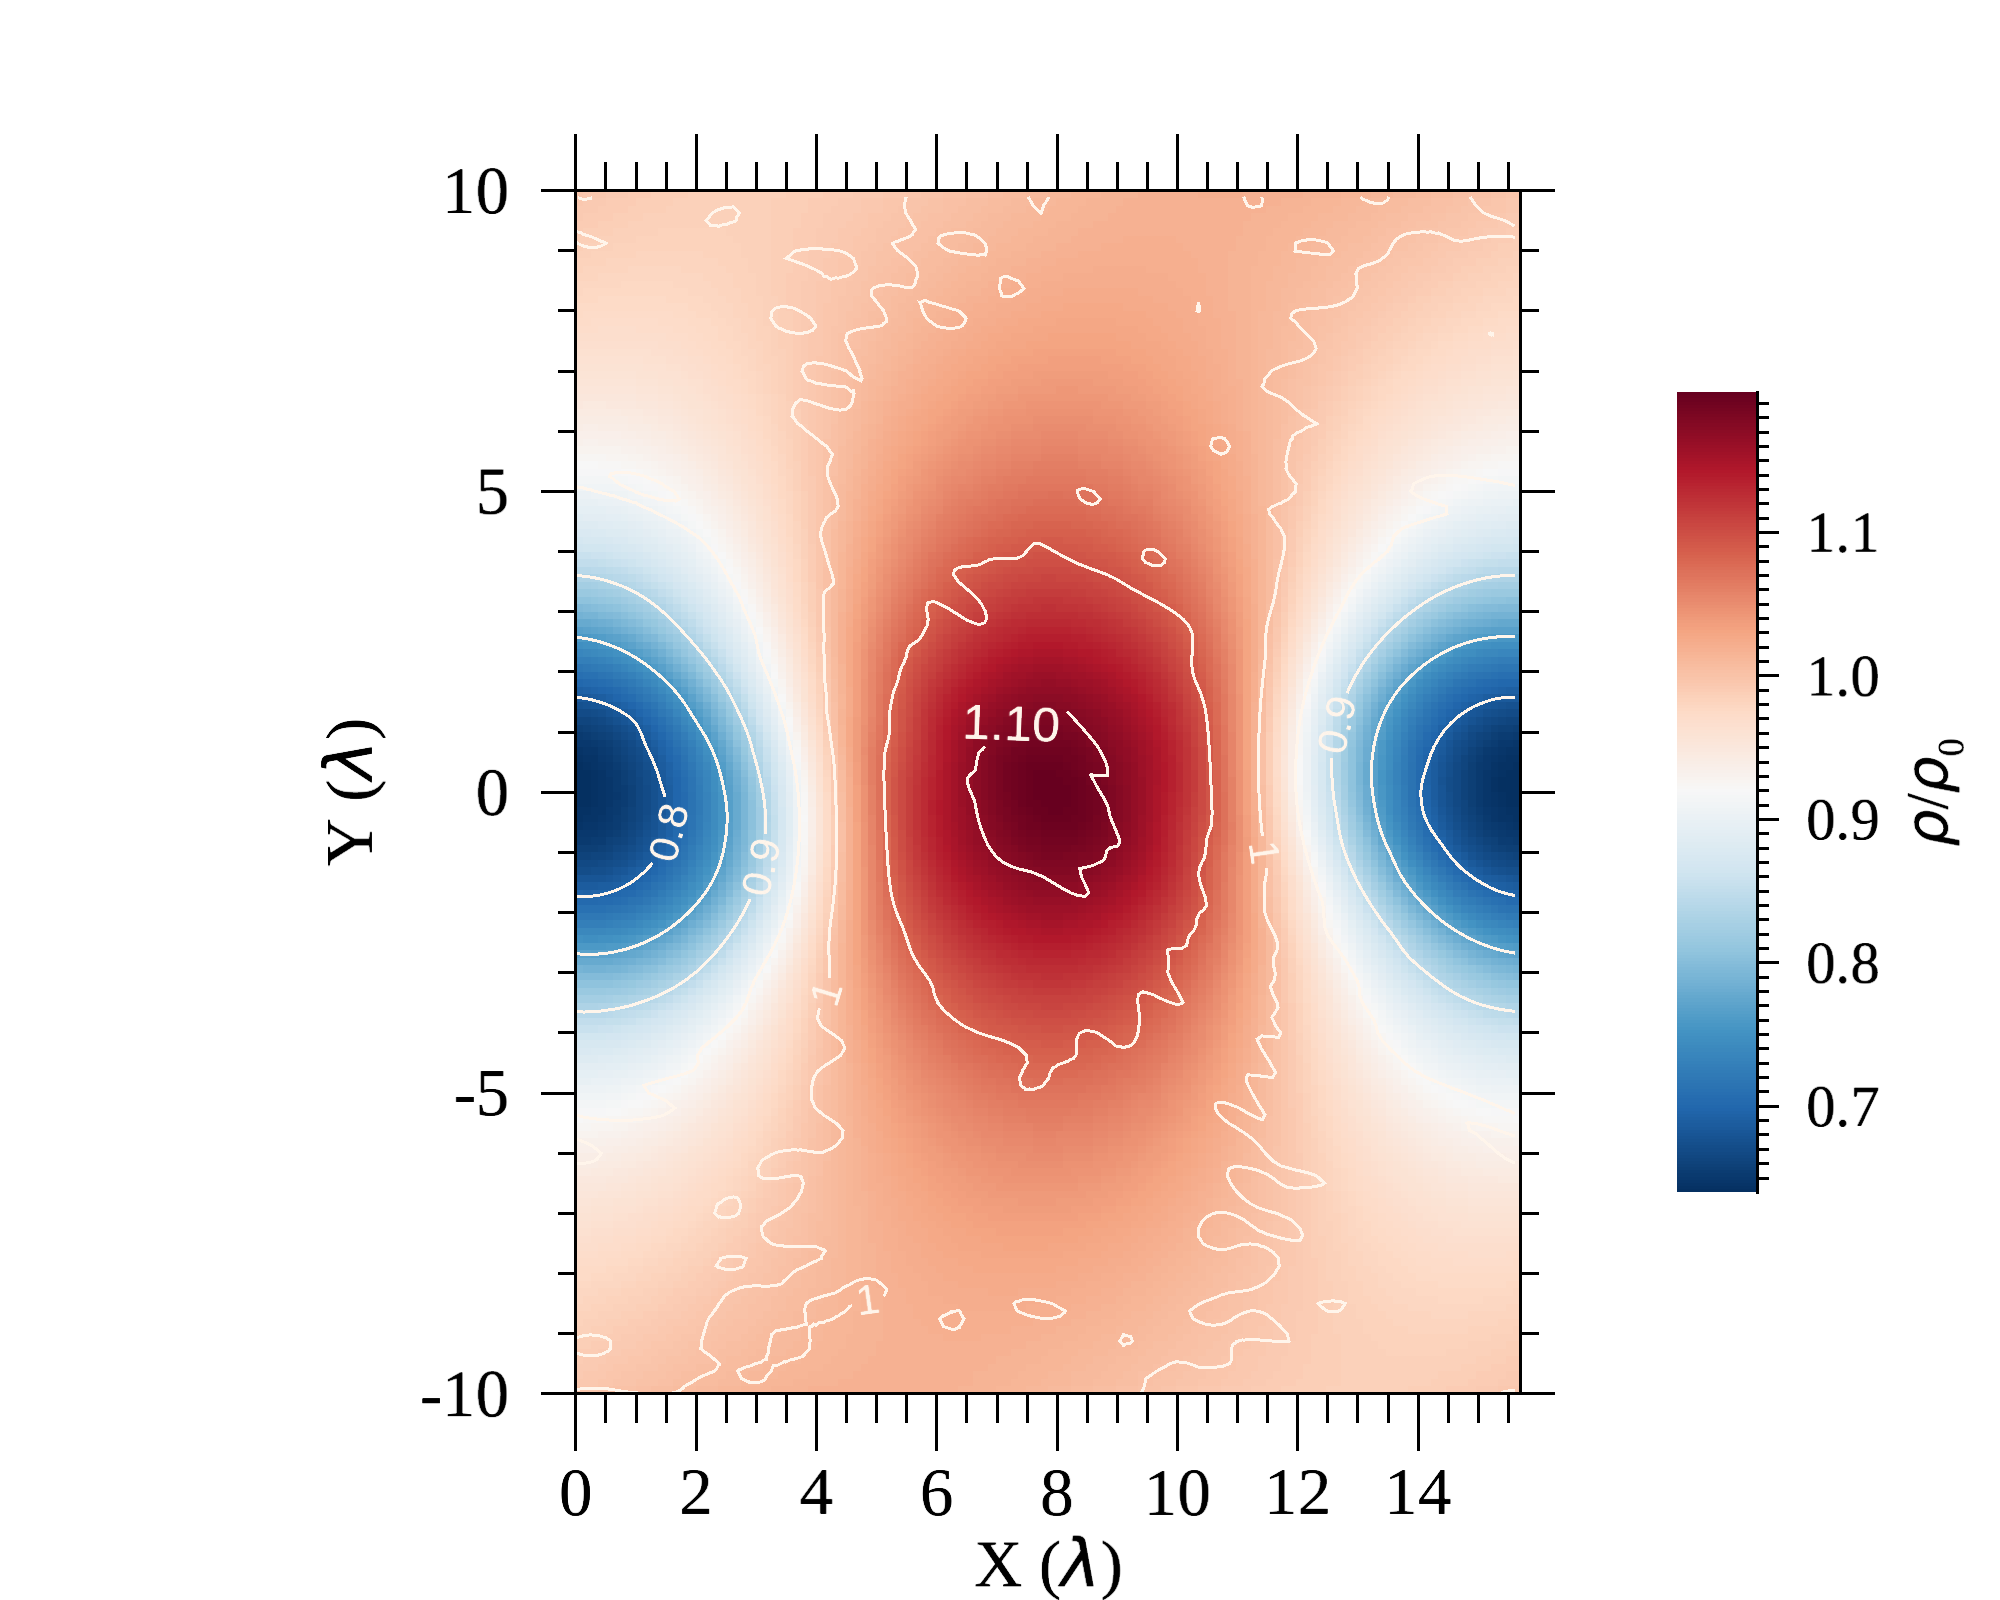

In [15]:
str.delete
cnt = contour(data[*,*,6],x-dx/2.,y-dy/2.,overplot=img,c_color=0)

等高線ラベルを削除、等高線の数を増やす場合は、

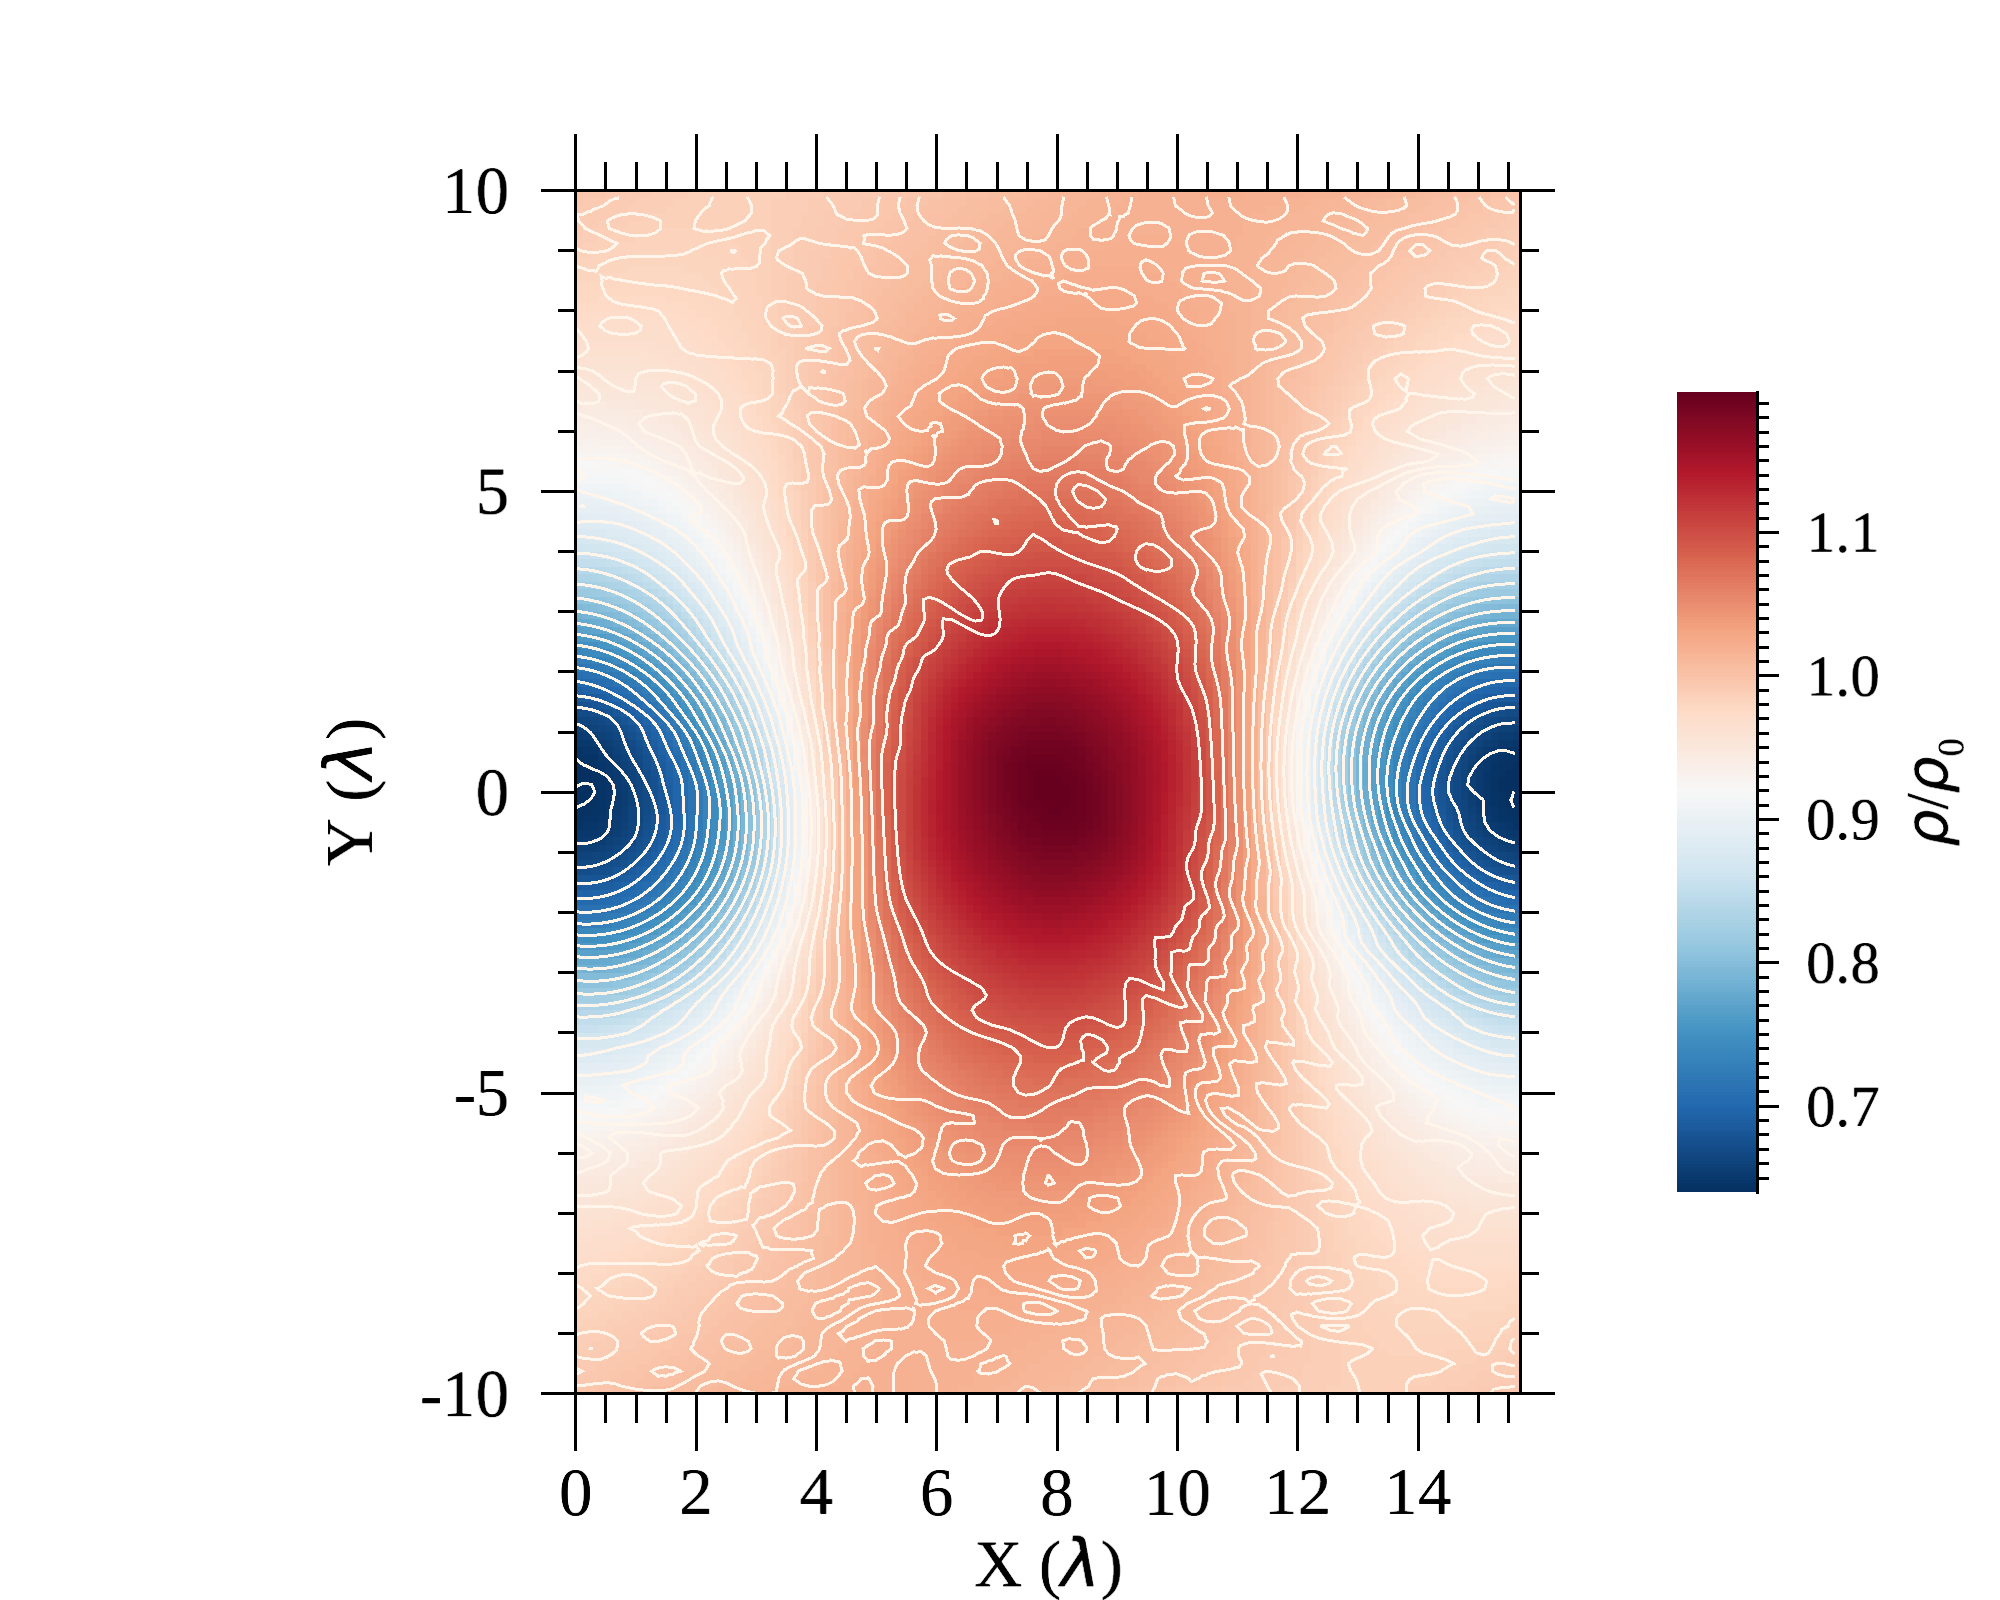

In [16]:
cnt.c_label_show=0
cnt.n_levels=30

# 結果のファイルへの出力
上記2次元マップで作成した図をファイルに保存するには、それぞれのクラスに共通したsaveメソッドを使ってファイルに保存します。ファイル名の拡張子からファイルフォーマットが自動的に決まります。

In [17]:
img.save,'result_idl.png',resolution=150;; DPI=150の画像で保存
img.save,'result_idl.eps'               ;; EPSで保存

## アニメーションの作り方
以下の様に、IDL上で結果をpngファイルとして保存します。

```IDL
IDL> restore,'sample_ro-time.dat'
IDL> info=size(ro,/dimension)
IDL> nt = info[2]
IDL> .run
for l=0,nt-1 do begin 
img = image(ro[*,*,l],x-dx/2.,y-dy/2.,axis_style=2,$
            xtickdir=1,ytickdir=1,rgb_table=33,/buffer)
img.save,'result_idl'+strcompress(string(l,format='(i3.3)'),/remove)+'.png',resolution=150
endfor
end
IDL> 
```

上記のようにすると、作業ディレクトリには”result_idl005.png”のように連番でファイル名が付けられた画像ファイルが作成されます。

結果をpngファイルに出力後、LinuxにインストールされているImagemagick (convert)やffmpegを使って、結果の図をアニメーション化します。まず、convertを使った方法を説明します。

```bash
$convert result???.png result.gif
```
のようにすると、gifアニメーションが作成されます。convertの際の詳しいオプションは”man convert”に委ねます。

次に、ffmpegを使ったアニメーション作成例を示します。
```bash
$ffmpeg -r 10 -i result_idl%03d.png -qscale 0 -vcodec mpeg4 result.mp4
```
のように、gifアニメーション以外のフォーマット（この例では、元の画像と同じ画質で、エンコードにmpeg4、格納形式としてmp4を指定している）の動画ファイルが作成可能です。更なるオプションは”man ffmpeg”に委ねます。